# **Librerías**

In [409]:
# Importamos librerías a utilizar

# --- Librerías base ---
import math
import warnings
import numpy as np
import pandas as pd
from pandas import DataFrame
from collections import Counter

warnings.simplefilter('ignore')

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from IPython.display import display

# --- Preprocesamiento ---
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# --- Selección de modelos y validación ---
from sklearn.model_selection import (
    train_test_split, cross_validate,
    GridSearchCV, RandomizedSearchCV, StratifiedKFold
)
from scipy.stats import loguniform, uniform

# --- Modelos de regresión ---
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

# --- Modelos de clasificación ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans

# --- Métricas ---
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score,
    classification_report, accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)

# --- Pipeline y composición ---
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

# --- Balanceo de clases ---
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# --- Deep Learning ---
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# --- Explicabilidad ---
import shap

# --- Utilidades ---
import joblib
import re

# **Carga de dataset**

In [289]:
file_path='weatherAUS.csv'

df = pd.read_csv(file_path)

# **1. EDA**

## Filtro de ciudades

In [290]:
# Ciudades a utilizar
locations = ['Albury','Sydney','SydneyAirport','Canberra','Melbourne','MelbourneAirport']

# Filtrar el DataFrame
df = df[df['Location'].isin(locations)].reset_index(drop=True)

In [291]:
df['Location'].unique()

<StringArray>
[          'Albury',           'Sydney',    'SydneyAirport',
         'Canberra', 'MelbourneAirport',        'Melbourne']
Length: 6, dtype: str

## Creación de RainfallTomorrow

In [292]:
# Se ordenan los datos cronológicamente por Location y Date para asegurar que la variable objetivo se asigne correctamente
df = df.sort_values(by=['Location', 'Date']).reset_index(drop=True)

# Se crea la variable objetivo de regresión 'RainfallTomorrow: el Rainfall del día siguiente para cada Location
df['RainfallTomorrow'] = df.groupby('Location')['Rainfall'].shift(-1)

In [293]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 19031 entries, 0 to 19030
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              19031 non-null  str    
 1   Location          19031 non-null  str    
 2   MinTemp           18529 non-null  float64
 3   MaxTemp           18534 non-null  float64
 4   Rainfall          18215 non-null  float64
 5   Evaporation       14284 non-null  float64
 6   Sunshine          14042 non-null  float64
 7   WindGustDir       17542 non-null  str    
 8   WindGustSpeed     17544 non-null  float64
 9   WindDir9am        17811 non-null  str    
 10  WindDir3pm        18695 non-null  str    
 11  WindSpeed9am      18761 non-null  float64
 12  WindSpeed3pm      18771 non-null  float64
 13  Humidity9am       18452 non-null  float64
 14  Humidity3pm       18498 non-null  float64
 15  Pressure9am       18291 non-null  float64
 16  Pressure3pm       18297 non-null  float64
 17  Clou

In [294]:
# Se obtiene Month a partir de Date para luego usarlo en las imputaciones de valores faltantes
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month

In [295]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0 2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1 2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2 2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3 2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4 2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Pressure9am  Pressure3pm  \
0           W           44.0          W  ...      1007.7       1007.1   
1         WNW           44.0        NNW  ...      1010.6       1007.8   
2         WSW           46.0          W  ...      1007.6       1008.7   
3          NE           24.0         SE  ...      1017.6       1012.8   
4           W           41.0        ENE  ...      1010.8       1006.0   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       8.0       NaN     16.9     21.8         No            No   
1       NaN       NaN     17.2     24.3         No            No   
2       NaN       2.0     21.0     23.2         No            No   
3       NaN       NaN     18.1     26.5         No            No   
4       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  Month  
0               0.0     12  
1               0.0     12  
2               0.0     12  
3               1.0     12  
4               0.2     12  

[5 rows x 25 columns]

## Renombramiento de variables

In [296]:
# Se renombran las columnas para incluir sus unidades
unidades = {
    'MinTemp': 'MinTemp (°C)', 'MaxTemp': 'MaxTemp (°C)',
    'Rainfall': 'RainfallToday (mm)', 'Evaporation': 'Evaporation (mm)',
    'Sunshine': 'Sunshine (h)', 'WindGustSpeed': 'WindGustSpeed (km/h)',
    'WindSpeed9am': 'WindSpeed9am (km/h)', 'WindSpeed3pm': 'WindSpeed3pm (km/h)',
    'Humidity9am': 'Humidity9am (%)', 'Humidity3pm': 'Humidity3pm (%)',
    'Pressure9am': 'Pressure9am (hPa)', 'Pressure3pm': 'Pressure3pm (hPa)',
    'Cloud9am': 'Cloud9am (oktas)', 'Cloud3pm': 'Cloud3pm (oktas)',
    'Temp9am': 'Temp9am (°C)', 'Temp3pm': 'Temp3pm (°C)', 'RainfallTomorrow': 'RainfallTomorrow (mm)'
}

df.rename(columns=unidades, inplace=True)

## Análisis de valores faltantes y visualizaciones

In [297]:
def porcentaje_nan(df):
    cant_nan = df.isna().sum()
    porcentaje_nan = (cant_nan / len(df)) * 100

    info_nan = pd.DataFrame({
        'Cantidad': cant_nan,
        'Porcentaje': porcentaje_nan
    })

    info_nan['Porcentaje'] = info_nan['Porcentaje'].apply(lambda x: f"{x:.2f}%")

    print(info_nan)

porcentaje_nan(df)

                       Cantidad Porcentaje
Date                          0      0.00%
Location                      0      0.00%
MinTemp (°C)                502      2.64%
MaxTemp (°C)                497      2.61%
RainfallToday (mm)          816      4.29%
Evaporation (mm)           4747     24.94%
Sunshine (h)               4989     26.22%
WindGustDir                1489      7.82%
WindGustSpeed (km/h)       1487      7.81%
WindDir9am                 1220      6.41%
WindDir3pm                  336      1.77%
WindSpeed9am (km/h)         270      1.42%
WindSpeed3pm (km/h)         260      1.37%
Humidity9am (%)             579      3.04%
Humidity3pm (%)             533      2.80%
Pressure9am (hPa)           740      3.89%
Pressure3pm (hPa)           734      3.86%
Cloud9am (oktas)           4429     23.27%
Cloud3pm (oktas)           4546     23.89%
Temp9am (°C)                514      2.70%
Temp3pm (°C)                504      2.65%
RainToday                   816      4.29%
RainTomorro

--- REPORTE DE LIMPIEZA ---
Registros iniciales: 19031
1. Cantidad de datos eliminados con más del 50% faltantes: 489
2. Cantidad de datos eliminados con valores faltantes en RainTomorrow o RainfallTomorrow: 336
3. Porcentaje de datos eliminados sobre total inicial: 4.34%
Registros totales finales: 18206


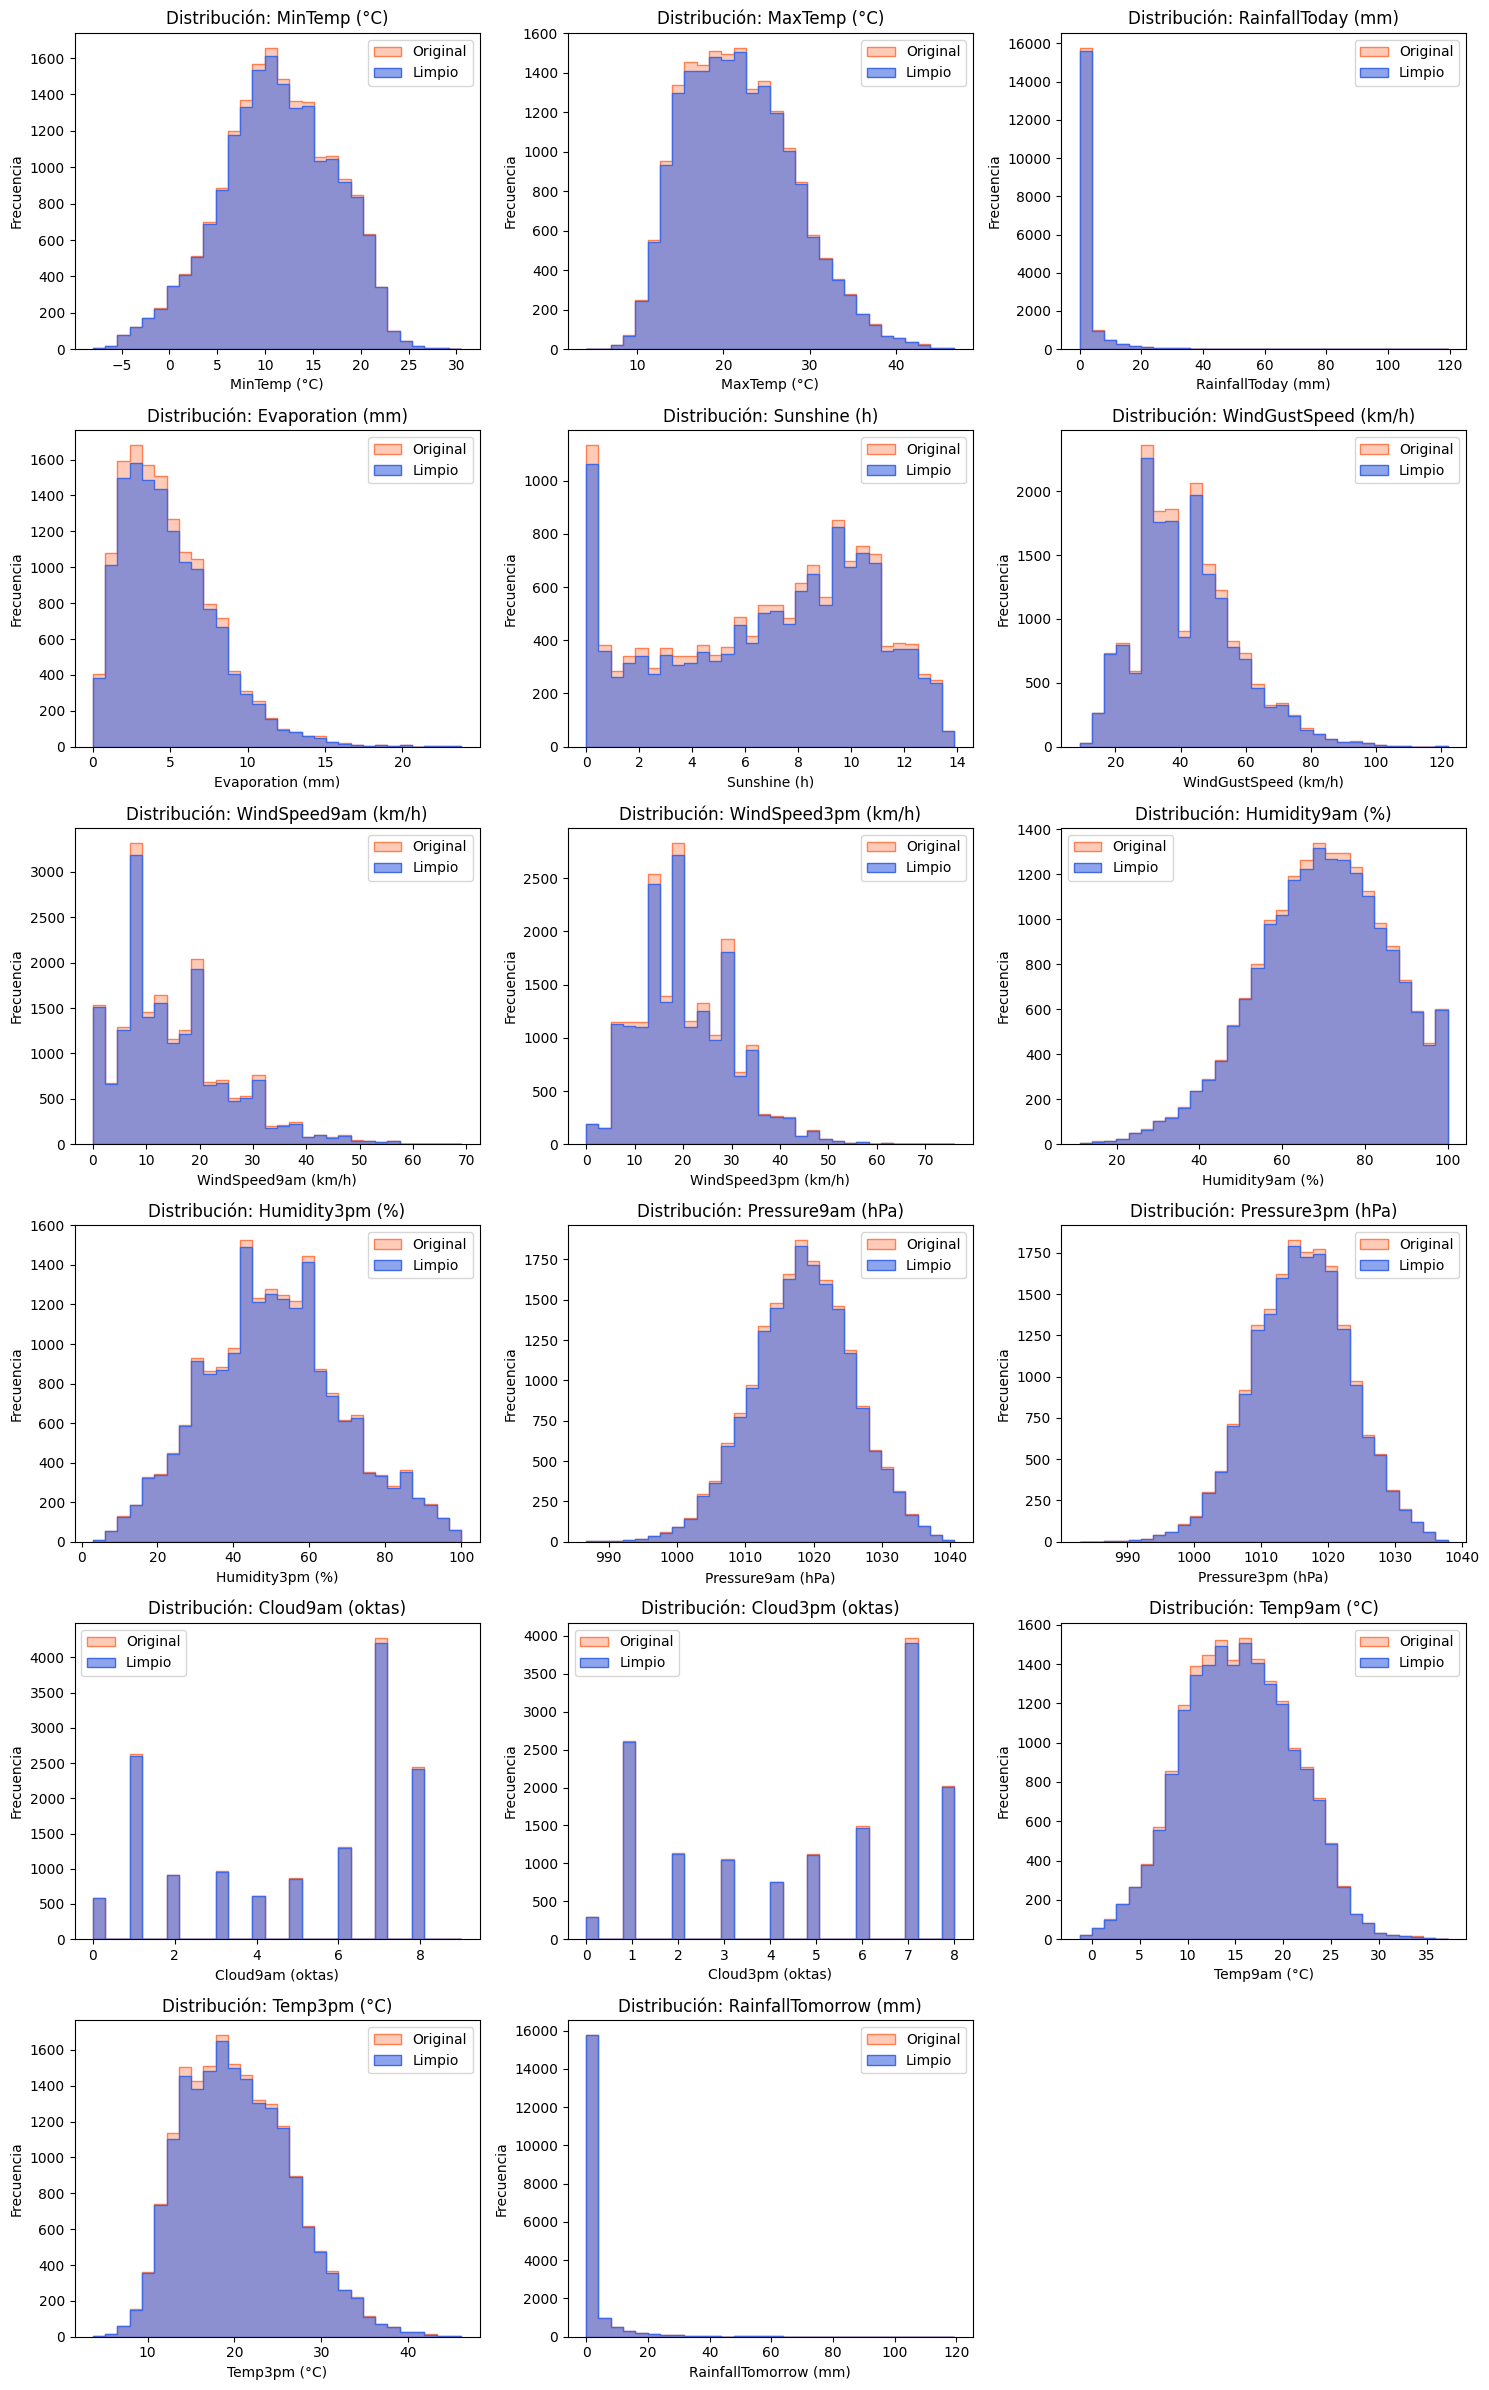

In [298]:
# Se guarda estado inicial para comparar
df_original = df.copy()
total_inicial = len(df)

# Se eliminan filas que contengan Nan en más de la mitad de las columnas
df = df.dropna(thresh=df.shape[1] // 2)
filas = len(df)

# Se eliminan filas con valores Nan en RainTomorrow o RainfallTomorrow
targets = ['RainTomorrow', 'RainfallTomorrow (mm)']
df = df.dropna(subset=targets).reset_index(drop=True)
filas_finales = len(df)


print(f"--- REPORTE DE LIMPIEZA ---")
print(f"Registros iniciales: {total_inicial}")
print(f"1. Cantidad de datos eliminados con más del 50% faltantes: {total_inicial - filas}")
print(f"2. Cantidad de datos eliminados con valores faltantes en RainTomorrow o RainfallTomorrow: {filas - filas_finales}")
print(f"3. Porcentaje de datos eliminados sobre total inicial: {((total_inicial - filas_finales)*100/total_inicial):.2f}%")
print(f"Registros totales finales: {filas_finales}")

# Visualizaciones
cols_num = [c for c in df.columns if '(' in c]
n_cols = 3
n_filas = (len(cols_num) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_filas, n_cols, figsize=(15, n_filas * 4))
axes = axes.flatten()

for i, col in enumerate(cols_num):
    # Histogramas con bins=30
    sns.histplot(df_original[col], color="coral", label="Original",
                 ax=axes[i], bins=30, element="step", alpha=0.4)

    sns.histplot(df[col], color="royalblue", label="Limpio",
                 ax=axes[i], bins=30, element="step", alpha=0.6)

    axes[i].set_title(f'Distribución: {col}')
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

# Limpiar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [299]:
# Mapeo de direcciones cardinales a grados
wind_dir_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

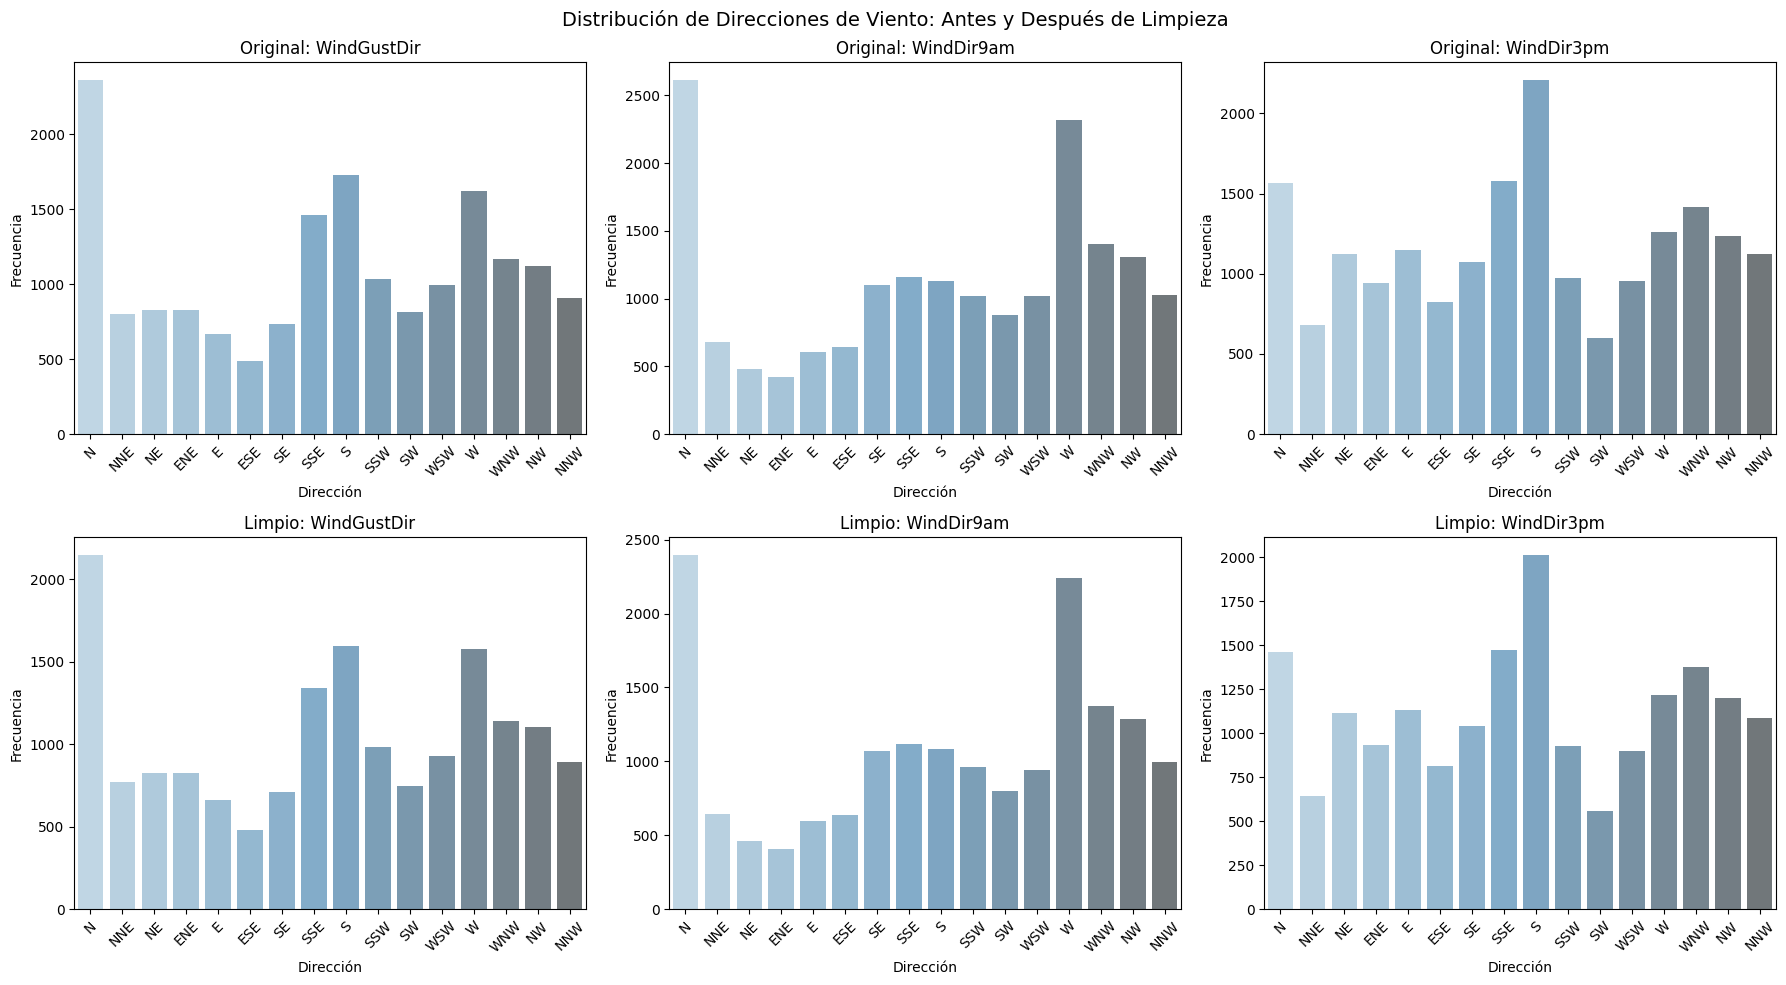

In [300]:
# Distribución de frecuencia de direcciones de viento (antes y después de limpieza)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
wind_cols_orig = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
order = list(wind_dir_map.keys())

for i, col in enumerate(wind_cols_orig):
    counts_orig = df_original[col].value_counts().reindex(order)
    counts_clean = df[col].value_counts().reindex(order)

    # Fila 1: Original
    sns.barplot(x=counts_orig.index, y=counts_orig.values, ax=axes[0, i], palette='Blues_d', alpha=0.7)
    axes[0, i].set_title(f'Original: {col}')
    axes[0, i].set_xlabel('Dirección')
    axes[0, i].set_ylabel('Frecuencia')
    axes[0, i].tick_params(axis='x', rotation=45)

    # Fila 2: Limpio
    sns.barplot(x=counts_clean.index, y=counts_clean.values, ax=axes[1, i], palette='Blues_d', alpha=0.7)
    axes[1, i].set_title(f'Limpio: {col}')
    axes[1, i].set_xlabel('Dirección')
    axes[1, i].set_ylabel('Frecuencia')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.suptitle('Distribución de Direcciones de Viento: Antes y Después de Limpieza', fontsize=14)
plt.tight_layout()
plt.show()

El reporte de limpieza dio como resultado un descarte del 4.34% del volumen inicial del dataset, garantizando que sigue siendo estadísticamente representativo de las ciudades seleccionadas.
Además, al comparar las distribuciones de las variables climáticas antes y después de la limpieza, se observa que no hubo desplazamientos significativos en las medias ni en las varianzas. Esto confirma que el proceso de limpieza fue no sesgado, preservando la naturaleza del fenómeno meteorológico.

In [301]:
porcentaje_nan(df)

                       Cantidad Porcentaje
Date                          0      0.00%
Location                      0      0.00%
MinTemp (°C)                 13      0.07%
MaxTemp (°C)                  7      0.04%
RainfallToday (mm)          183      1.01%
Evaporation (mm)           4704     25.84%
Sunshine (h)               4946     27.17%
WindGustDir                1452      7.98%
WindGustSpeed (km/h)       1450      7.96%
WindDir9am                 1192      6.55%
WindDir3pm                  327      1.80%
WindSpeed9am (km/h)         261      1.43%
WindSpeed3pm (km/h)         253      1.39%
Humidity9am (%)              89      0.49%
Humidity3pm (%)              49      0.27%
Pressure9am (hPa)           250      1.37%
Pressure3pm (hPa)           246      1.35%
Cloud9am (oktas)           3767     20.69%
Cloud3pm (oktas)           3875     21.28%
Temp9am (°C)                 25      0.14%
Temp3pm (°C)                 20      0.11%
RainToday                   183      1.01%
RainTomorro

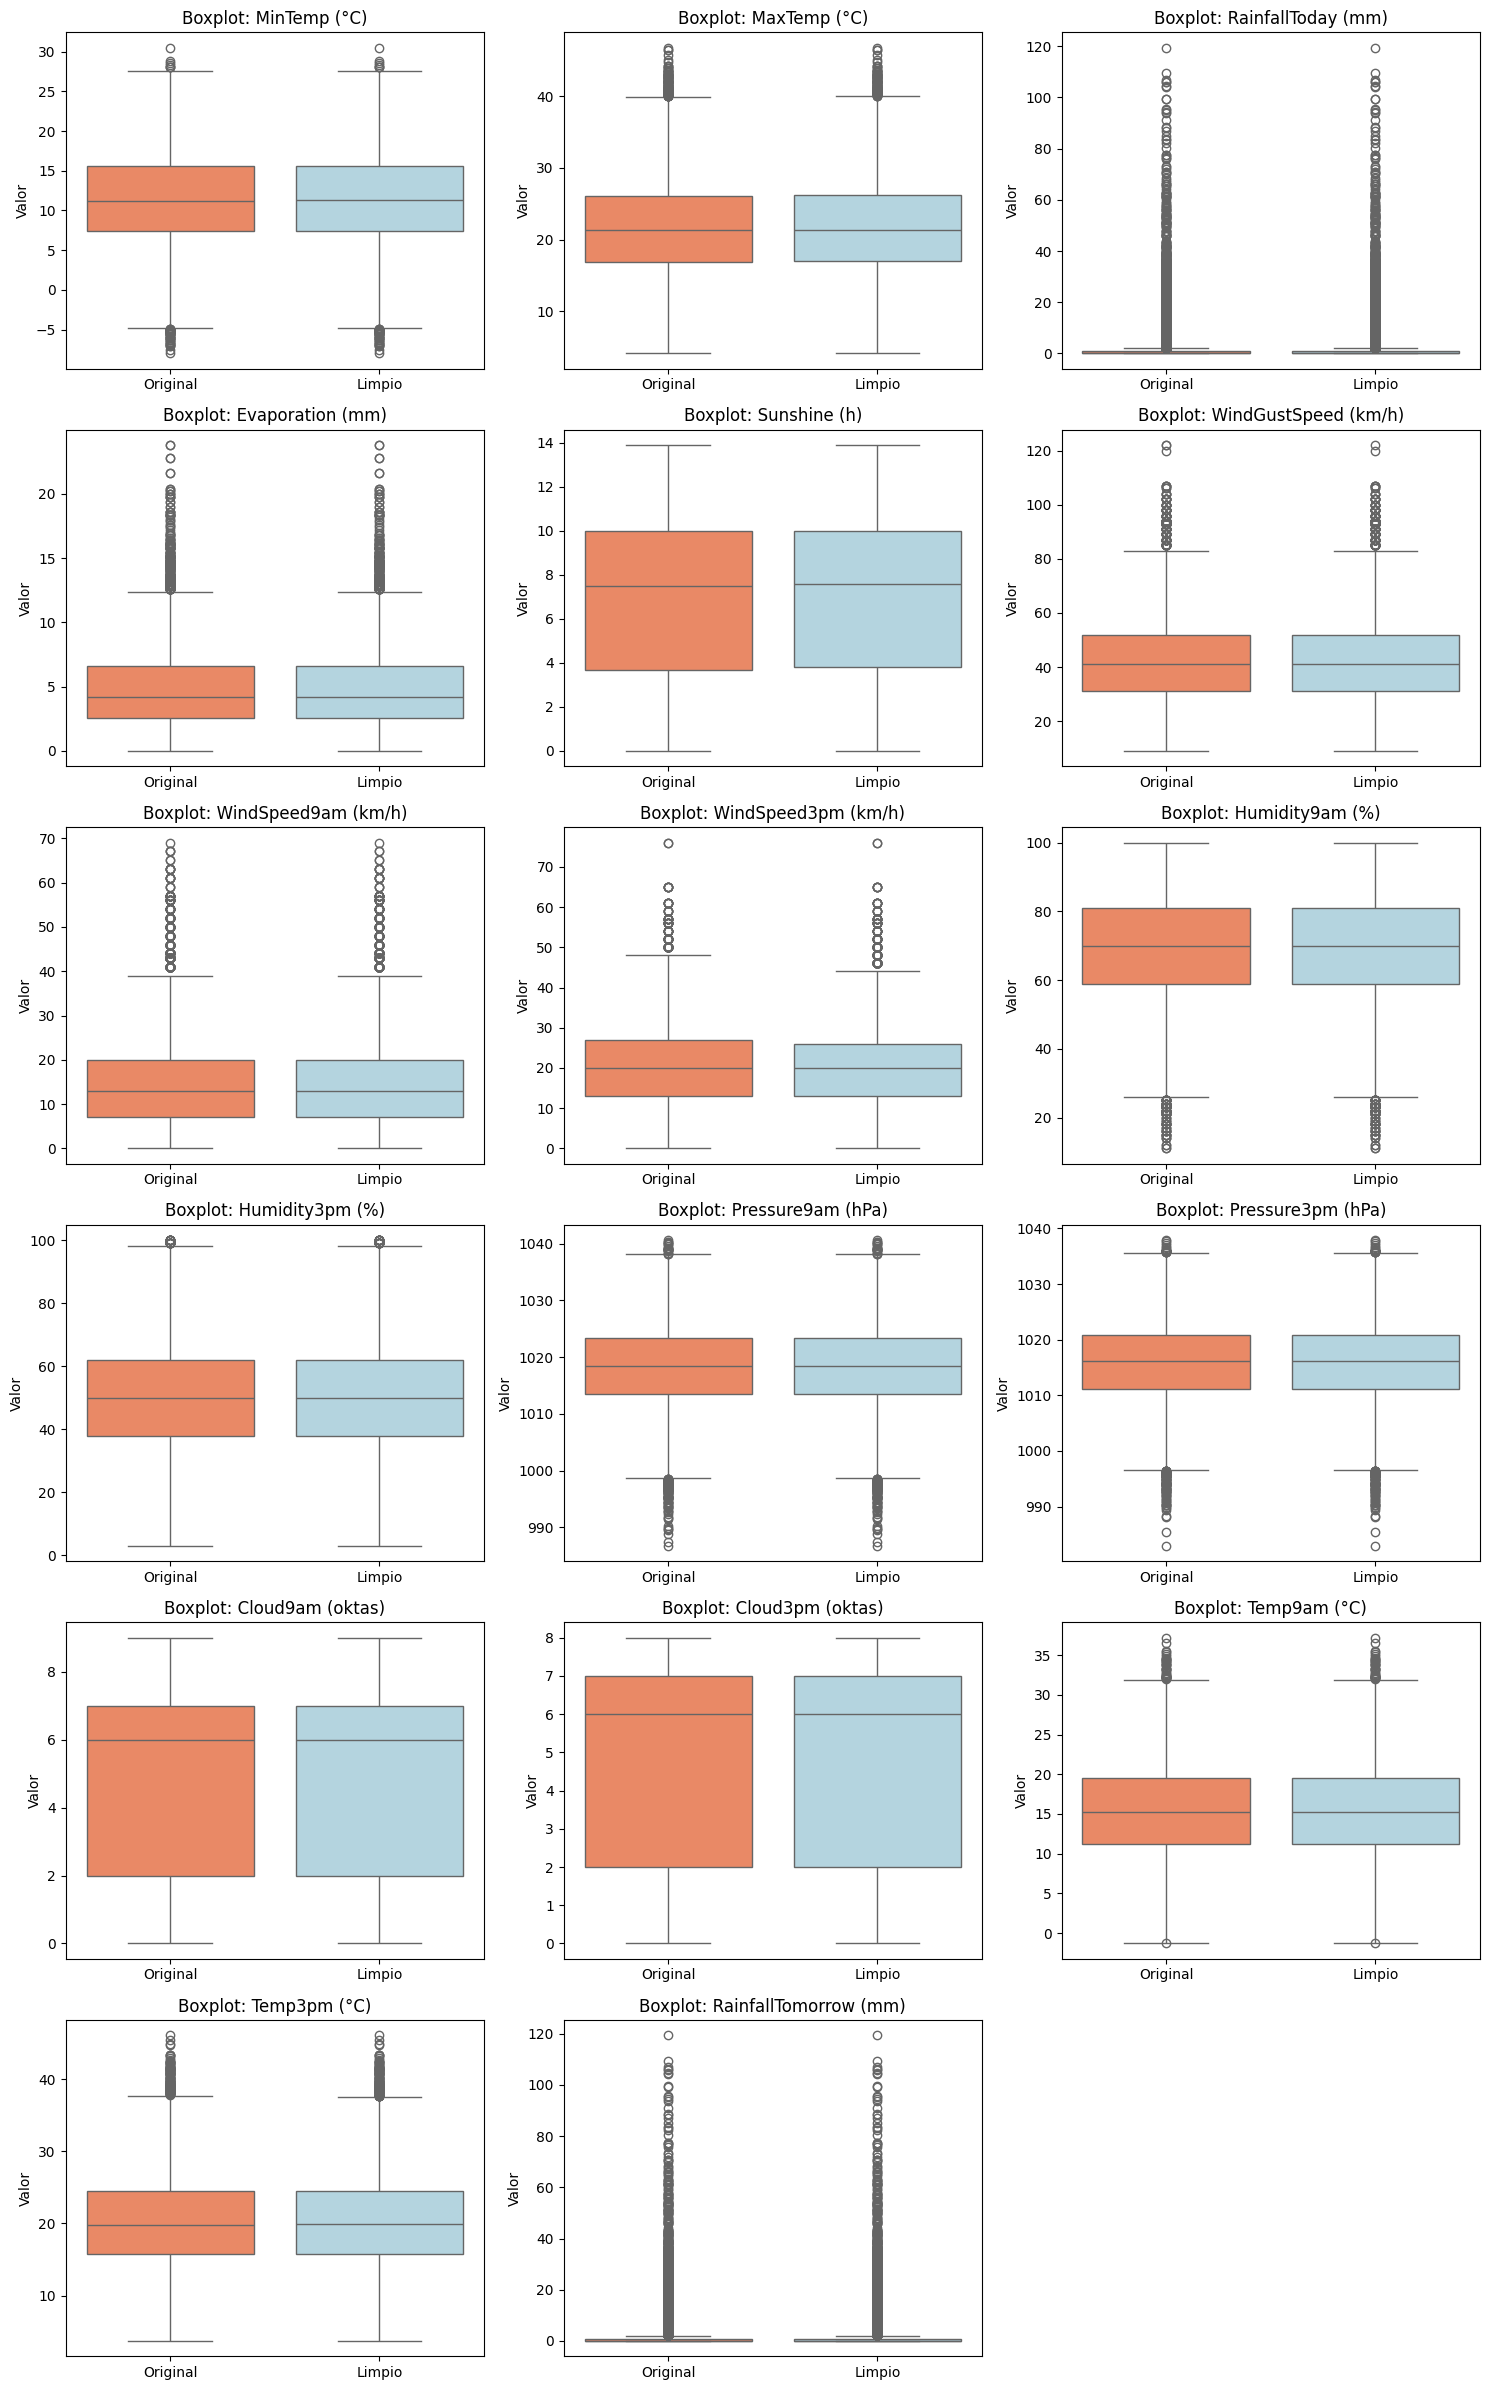

In [302]:
# Boxplots
fig, axes = plt.subplots(n_filas, n_cols, figsize=(15, n_filas * 4))
axes = axes.flatten()

for i, col in enumerate(cols_num):
    temp_df = pd.concat([
        pd.DataFrame({col: df_original[col], 'Estado': 'Original'}),
        pd.DataFrame({col: df[col], 'Estado': 'Limpio'})
    ]).reset_index(drop=True)

    sns.boxplot(data=temp_df, x='Estado', y=col, ax=axes[i],
                palette={'Original': 'coral', 'Limpio': 'lightblue'},
                hue='Estado', legend=False)

    axes[i].set_title(f'Boxplot: {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Valor')

# Limpiar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Con estos boxplots se confirma lo analizado en la visualización de distribuciones anterior, que las mismas no fueron afectadas por la limpieza inicial. A su vez, se pueden observar valores atípicos en algunas variables propios de las características climáticas que representan.

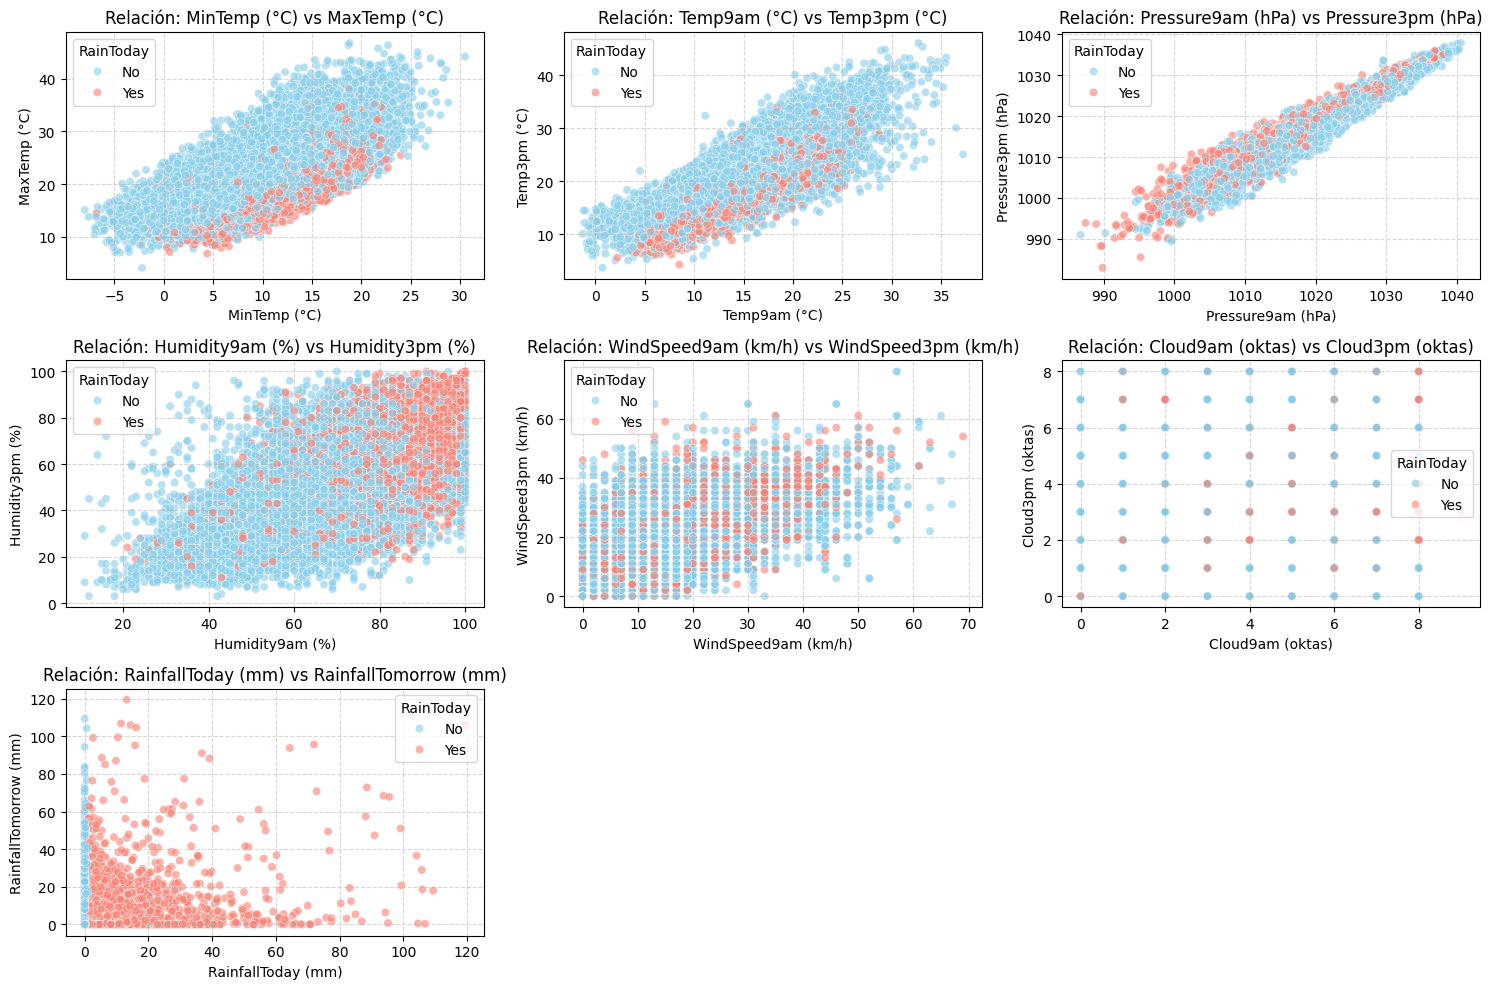

In [303]:
# Scatterplots para variables relacionadas
pares_similares = [
    ('MinTemp (°C)', 'MaxTemp (°C)'),
    ('Temp9am (°C)', 'Temp3pm (°C)'),
    ('Pressure9am (hPa)', 'Pressure3pm (hPa)'),
    ('Humidity9am (%)', 'Humidity3pm (%)'),
    ('WindSpeed9am (km/h)', 'WindSpeed3pm (km/h)'),
    ('Cloud9am (oktas)', 'Cloud3pm (oktas)'),
    ('RainfallToday (mm)', 'RainfallTomorrow (mm)')
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (col_x, col_y) in enumerate(pares_similares):
    # Se grafican si ambas columnas existen en el dataframe
    if col_x in df.columns and col_y in df.columns:
        sns.scatterplot(
            data=df,
            x=col_x,
            y=col_y,
            hue='RainToday',
            palette={'No': 'skyblue', 'Yes': 'salmon'},
            alpha=0.6,
            ax=axes[i]
        )
        axes[i].set_title(f'Relación: {col_x} vs {col_y}')
        axes[i].grid(True, linestyle='--', alpha=0.5)


# Limpiar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar diseño
plt.tight_layout()
plt.show()

Los primeros tres scatterplots muestran una correlación lineal fuerte entre los pares de variables aunque la separación de clases (RainToday Yes/No) no es clara, por lo que estas variables no discriminan bien la lluvia por si solas.
En el caso de la humedad, los datos estás más dispersos, reflejando una relación menos lineal. Se puede observar que los valores altos de humedad se asocian más a días lluviosos.
WindSpeed9am vs WindSpeed3pm
Tanto los valores de la velocidad del viento como los de nubosidad son discretos, lo que da como resultado que los puntos se apilen en líneas, dando una apariencia de cuadrícula. 
El scatterplot de Rainfall muestra una alta concentración de valores en 0, con cola larga a la derecha, lo que dificulta su lectura.

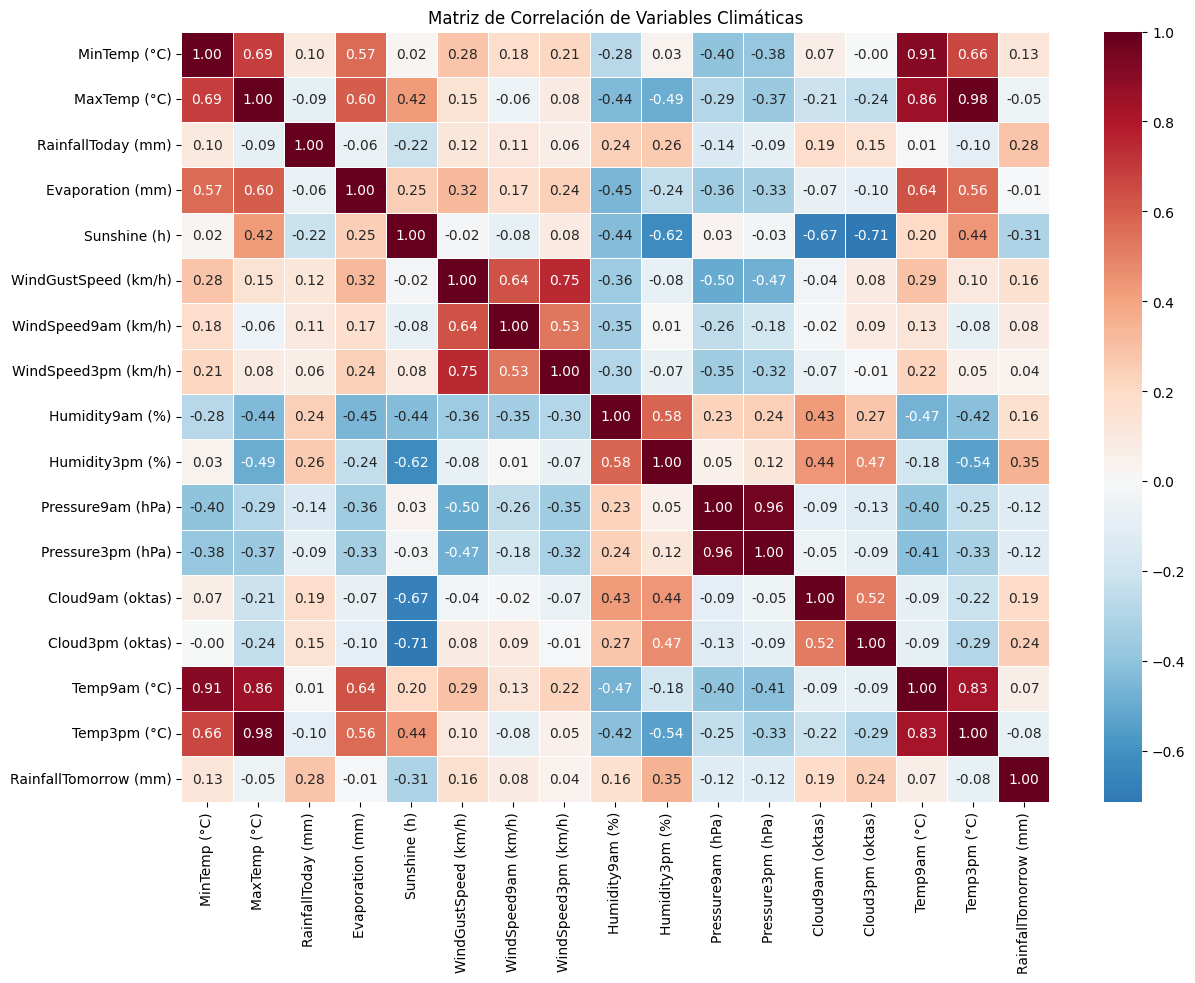

In [304]:
# --- Matriz de Correlación ---
plt.figure(figsize=(14, 10))

# Calculamos la correlación solo para variables numéricas
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Creamos el mapa de calor
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', center=0, linewidths=0.5)

plt.title('Matriz de Correlación de Variables Climáticas')
plt.show()

En cuanto a las correlaciones positivas más fuertes, se destaca la relación entre Pressure9am y Pressure3pm, lo que indica que la presión atmosférica se mantiene estable a lo largo del día. Lo mismo sucedde con MinTemp y Temp9am, y con MaxTemp y Temp3pm, confirmando que la temperatura mínima diaria ocurre en las primeras horas de la mañana y que la temperatura máxima se alcanza cerca de las 3pm. WindGustSpeed y WindSpeed3pm también muestran una correlación alta, sugiriendo que las ráfagas de viento más intensas ocurren durante la tarde.

Respecto a las correlaciones negativas más relevantes, Sunshine presenta relaciones inversas con Cloud9am y Cloud3pm, lo que es físicamente esperado: a mayor nubosidad, menor cantidad de horas de sol. También se observa algo similar entre Humidity3pm y Sunshine, indicando que los días más soleados tienden a ser menos húmedos.

En relación a la variable objetivo RainfallTomorrow, ninguna variable supera una correlación de 0.35, siendo Humidity3pm y Sunshine las más relevantes. Esto evidencia que la lluvia del día siguiente no tiene una dependencia lineal fuerte con ninguna variable individual, lo que justifica el uso de modelos más complejos con mayor capacidad de capturar relaciones no lineales.

Finalmente, la alta correlación entre pares como MinTemp/Temp9am, MaxTemp/Temp3pm y Pressure9am/Pressure3pm introduce multicolinealidad, aportando información redundante en modelos de regresión lineal. Esto refuerza la importancia de aplicar técnicas de regularización.

## Split incial train_val - test

In [305]:
# Se separan variables predictoras y variables objetivo
X = df.drop(columns=['RainTomorrow', 'RainfallTomorrow (mm)', 'Date'])
y_reg = df['RainfallTomorrow (mm)']    # Objetivo para Regresión (Cantidad)
y_class = df['RainTomorrow']            # Objetivo para Clasificación (Yes/No)

# Train-val - test split para ambas targets
# Stratify=y_class para mantener la proporción de lluvia en los sets
X_train_val, X_test, y_train_val_class, y_test_class, y_train_val_reg, y_test_reg = train_test_split(
    X,
    y_class,
    y_reg,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

# Verificación de que todo coincida
print(f"Filas en X_train_val: {len(X_train_val)}")
print(f"Filas en y_train_val_class: {len(y_train_val_class)}")
print(f"Filas en y_train_val_reg: {len(y_train_val_reg)}")

Filas en X_train_val: 14564
Filas en y_train_val_class: 14564
Filas en y_train_val_reg: 14564


## Imputación

In [306]:
def imputar_numericas_por_grupo(df_train, df_test, cols_mediana):
    df_train_imputed = df_train.copy()
    df_test_imputed = df_test.copy()

    for col in cols_mediana:
        # Mediana por Location y Month de Train
        dict_loc_month = df_train.groupby(['Location', 'Month'])[col].median().to_dict()
        # Mediana por Mes (promedio de todas las ciudades en ese mes)
        dict_month_only = df_train.groupby(['Month'])[col].median().to_dict()

        def apply_cascade(row):
            val = row[col]
            if pd.isna(val):
                val = dict_loc_month.get((row['Location'], row['Month']), np.nan)
                # Solo Mes (si el anterior fue NaN)
                if pd.isna(val):
                    val = dict_month_only.get(row['Month'], np.nan)
            return val

        # Aplicar en Train y Test
        df_train_imputed[col] = df_train_imputed.apply(apply_cascade, axis=1)
        df_test_imputed[col] = df_test_imputed.apply(apply_cascade, axis=1)

    return df_train_imputed, df_test_imputed

def imputar_categoricas_por_grupo(df_train, df_test, cols_categoricas):
    df_train_imputed = df_train.copy()
    df_test_imputed = df_test.copy()

    for col in cols_categoricas:
        # Moda por Location y Month de Train
        dict_loc_month = df_train.groupby(['Location', 'Month'])[col].apply(
            lambda x: x.mode()[0] if not x.mode().empty else np.nan
        ).to_dict()
        # Moda por Mes (promedio de todas las ciudades en ese mes)
        dict_month_only = df_train.groupby(['Month'])[col].apply(
            lambda x: x.mode()[0] if not x.mode().empty else np.nan
        ).to_dict()

        def apply_cascade_cat(row):
            val = row[col]
            if pd.isna(val):
                val = dict_loc_month.get((row['Location'], row['Month']), np.nan)
                # Solo Mes (si el anterior fue NaN)
                if pd.isna(val):
                    val = dict_month_only.get(row['Month'], np.nan)
            return val

        # Aplicar en Train y Test
        df_train_imputed[col] = df_train_imputed.apply(apply_cascade_cat, axis=1)
        df_test_imputed[col] = df_test_imputed.apply(apply_cascade_cat, axis=1)

    return df_train_imputed, df_test_imputed

In [307]:
# División en columnas numéricas y categóricas para imputación
cols_num = [
    'MinTemp (°C)', 'MaxTemp (°C)', 'RainfallToday (mm)', 'Evaporation (mm)',
    'Sunshine (h)', 'WindGustSpeed (km/h)', 'WindSpeed9am (km/h)',
    'WindSpeed3pm (km/h)', 'Humidity9am (%)', 'Humidity3pm (%)',
    'Pressure9am (hPa)', 'Pressure3pm (hPa)', 'Cloud9am (oktas)',
    'Cloud3pm (oktas)', 'Temp9am (°C)', 'Temp3pm (°C)'
]

cols_cat = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [308]:
# Imputación de valores faltantes por grupo
X_train_val_num, X_test_num = imputar_numericas_por_grupo(X_train_val, X_test, cols_num)
X_train_val_imp, X_test_imp = imputar_categoricas_por_grupo(X_train_val_num, X_test_num, cols_cat)

### Verificación de la imputación

In [309]:
porcentaje_nan(X_train_val_imp)

                      Cantidad Porcentaje
Location                     0      0.00%
MinTemp (°C)                 0      0.00%
MaxTemp (°C)                 0      0.00%
RainfallToday (mm)           0      0.00%
Evaporation (mm)             0      0.00%
Sunshine (h)                 0      0.00%
WindGustDir                  0      0.00%
WindGustSpeed (km/h)         0      0.00%
WindDir9am                   0      0.00%
WindDir3pm                   0      0.00%
WindSpeed9am (km/h)          0      0.00%
WindSpeed3pm (km/h)          0      0.00%
Humidity9am (%)              0      0.00%
Humidity3pm (%)              0      0.00%
Pressure9am (hPa)            0      0.00%
Pressure3pm (hPa)            0      0.00%
Cloud9am (oktas)             0      0.00%
Cloud3pm (oktas)             0      0.00%
Temp9am (°C)                 0      0.00%
Temp3pm (°C)                 0      0.00%
RainToday                    0      0.00%
Month                        0      0.00%


In [310]:
porcentaje_nan(X_test_imp)

                      Cantidad Porcentaje
Location                     0      0.00%
MinTemp (°C)                 0      0.00%
MaxTemp (°C)                 0      0.00%
RainfallToday (mm)           0      0.00%
Evaporation (mm)             0      0.00%
Sunshine (h)                 0      0.00%
WindGustDir                  0      0.00%
WindGustSpeed (km/h)         0      0.00%
WindDir9am                   0      0.00%
WindDir3pm                   0      0.00%
WindSpeed9am (km/h)          0      0.00%
WindSpeed3pm (km/h)          0      0.00%
Humidity9am (%)              0      0.00%
Humidity3pm (%)              0      0.00%
Pressure9am (hPa)            0      0.00%
Pressure3pm (hPa)            0      0.00%
Cloud9am (oktas)             0      0.00%
Cloud3pm (oktas)             0      0.00%
Temp9am (°C)                 0      0.00%
Temp3pm (°C)                 0      0.00%
RainToday                    0      0.00%
Month                        0      0.00%


### Visualizaciones 

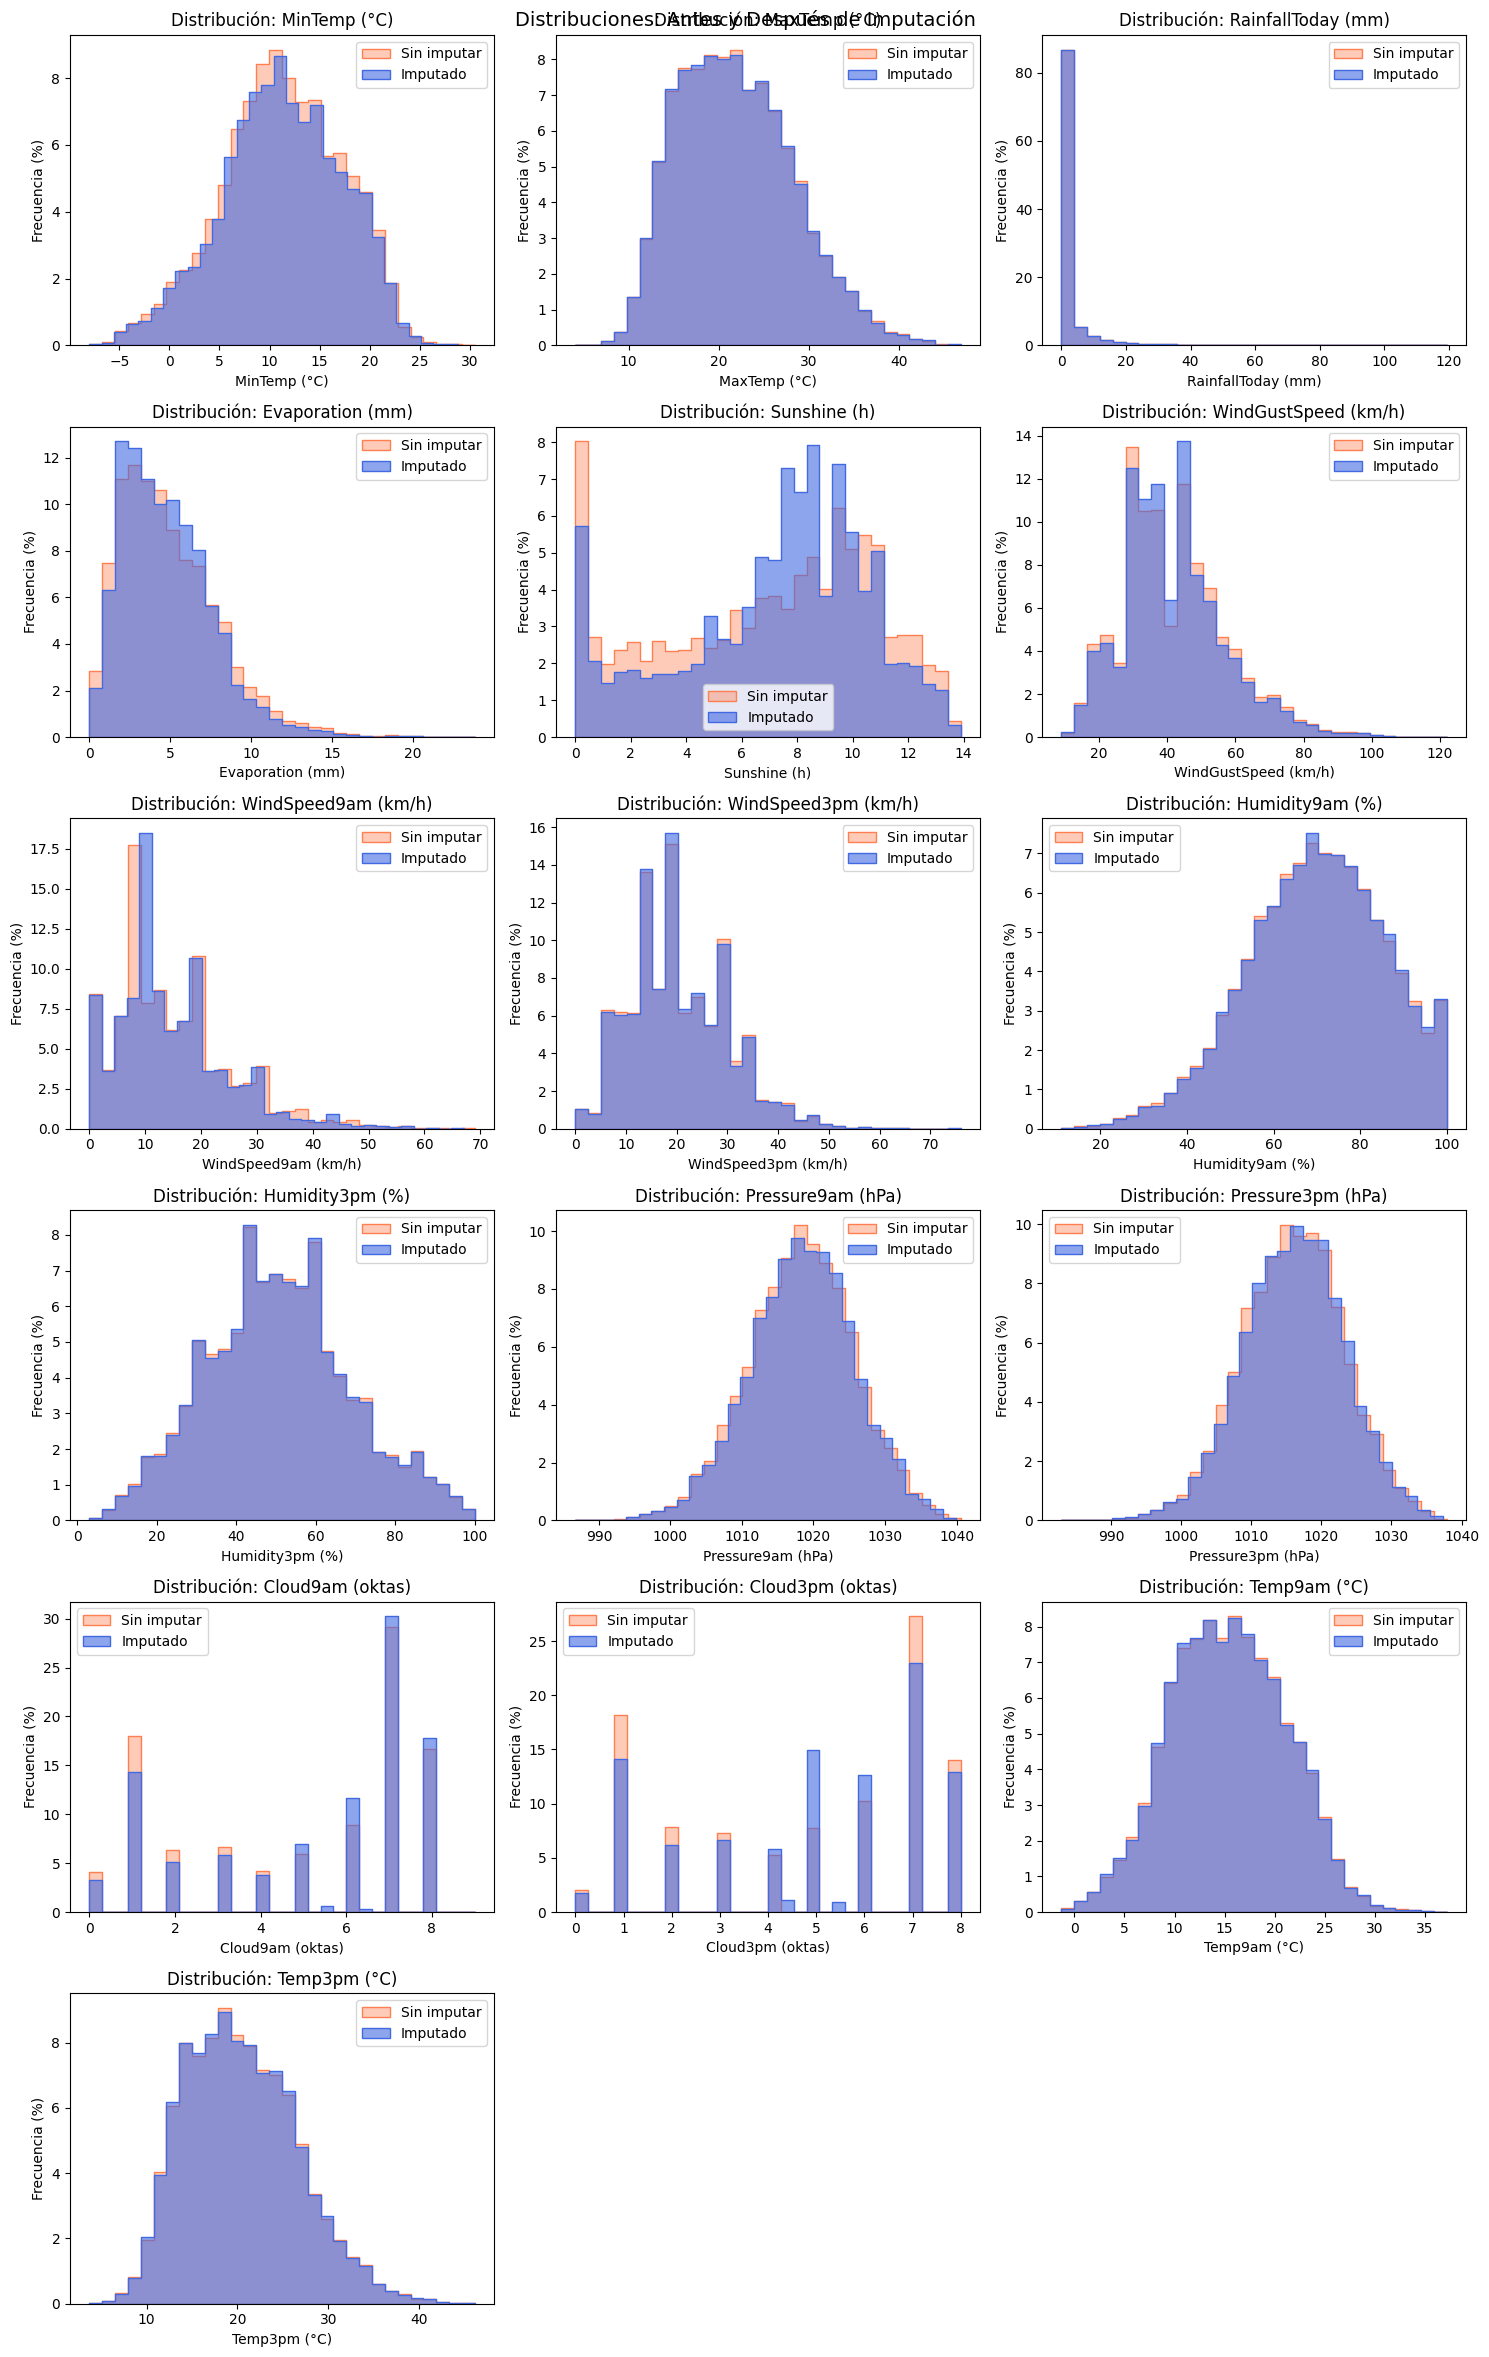

In [311]:
# ---- Histogramas: antes y después de imputación ----
fig, axes = plt.subplots(n_filas_imp, n_cols, figsize=(15, n_filas_imp * 4))
axes = axes.flatten()

for i, col in enumerate(cols_num_imp):
    sns.histplot(df[col], color="coral", label="Sin imputar",
                 ax=axes[i], bins=30, element="step", alpha=0.4, stat='percent')
    sns.histplot(X_train_val_imp[col], color="royalblue", label="Imputado",
                 ax=axes[i], bins=30, element="step", alpha=0.6, stat='percent')
    axes[i].set_title(f'Distribución: {col}')
    axes[i].set_ylabel('Frecuencia (%)')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribuciones: Antes y Después de Imputación', fontsize=14)
plt.tight_layout()
plt.show()

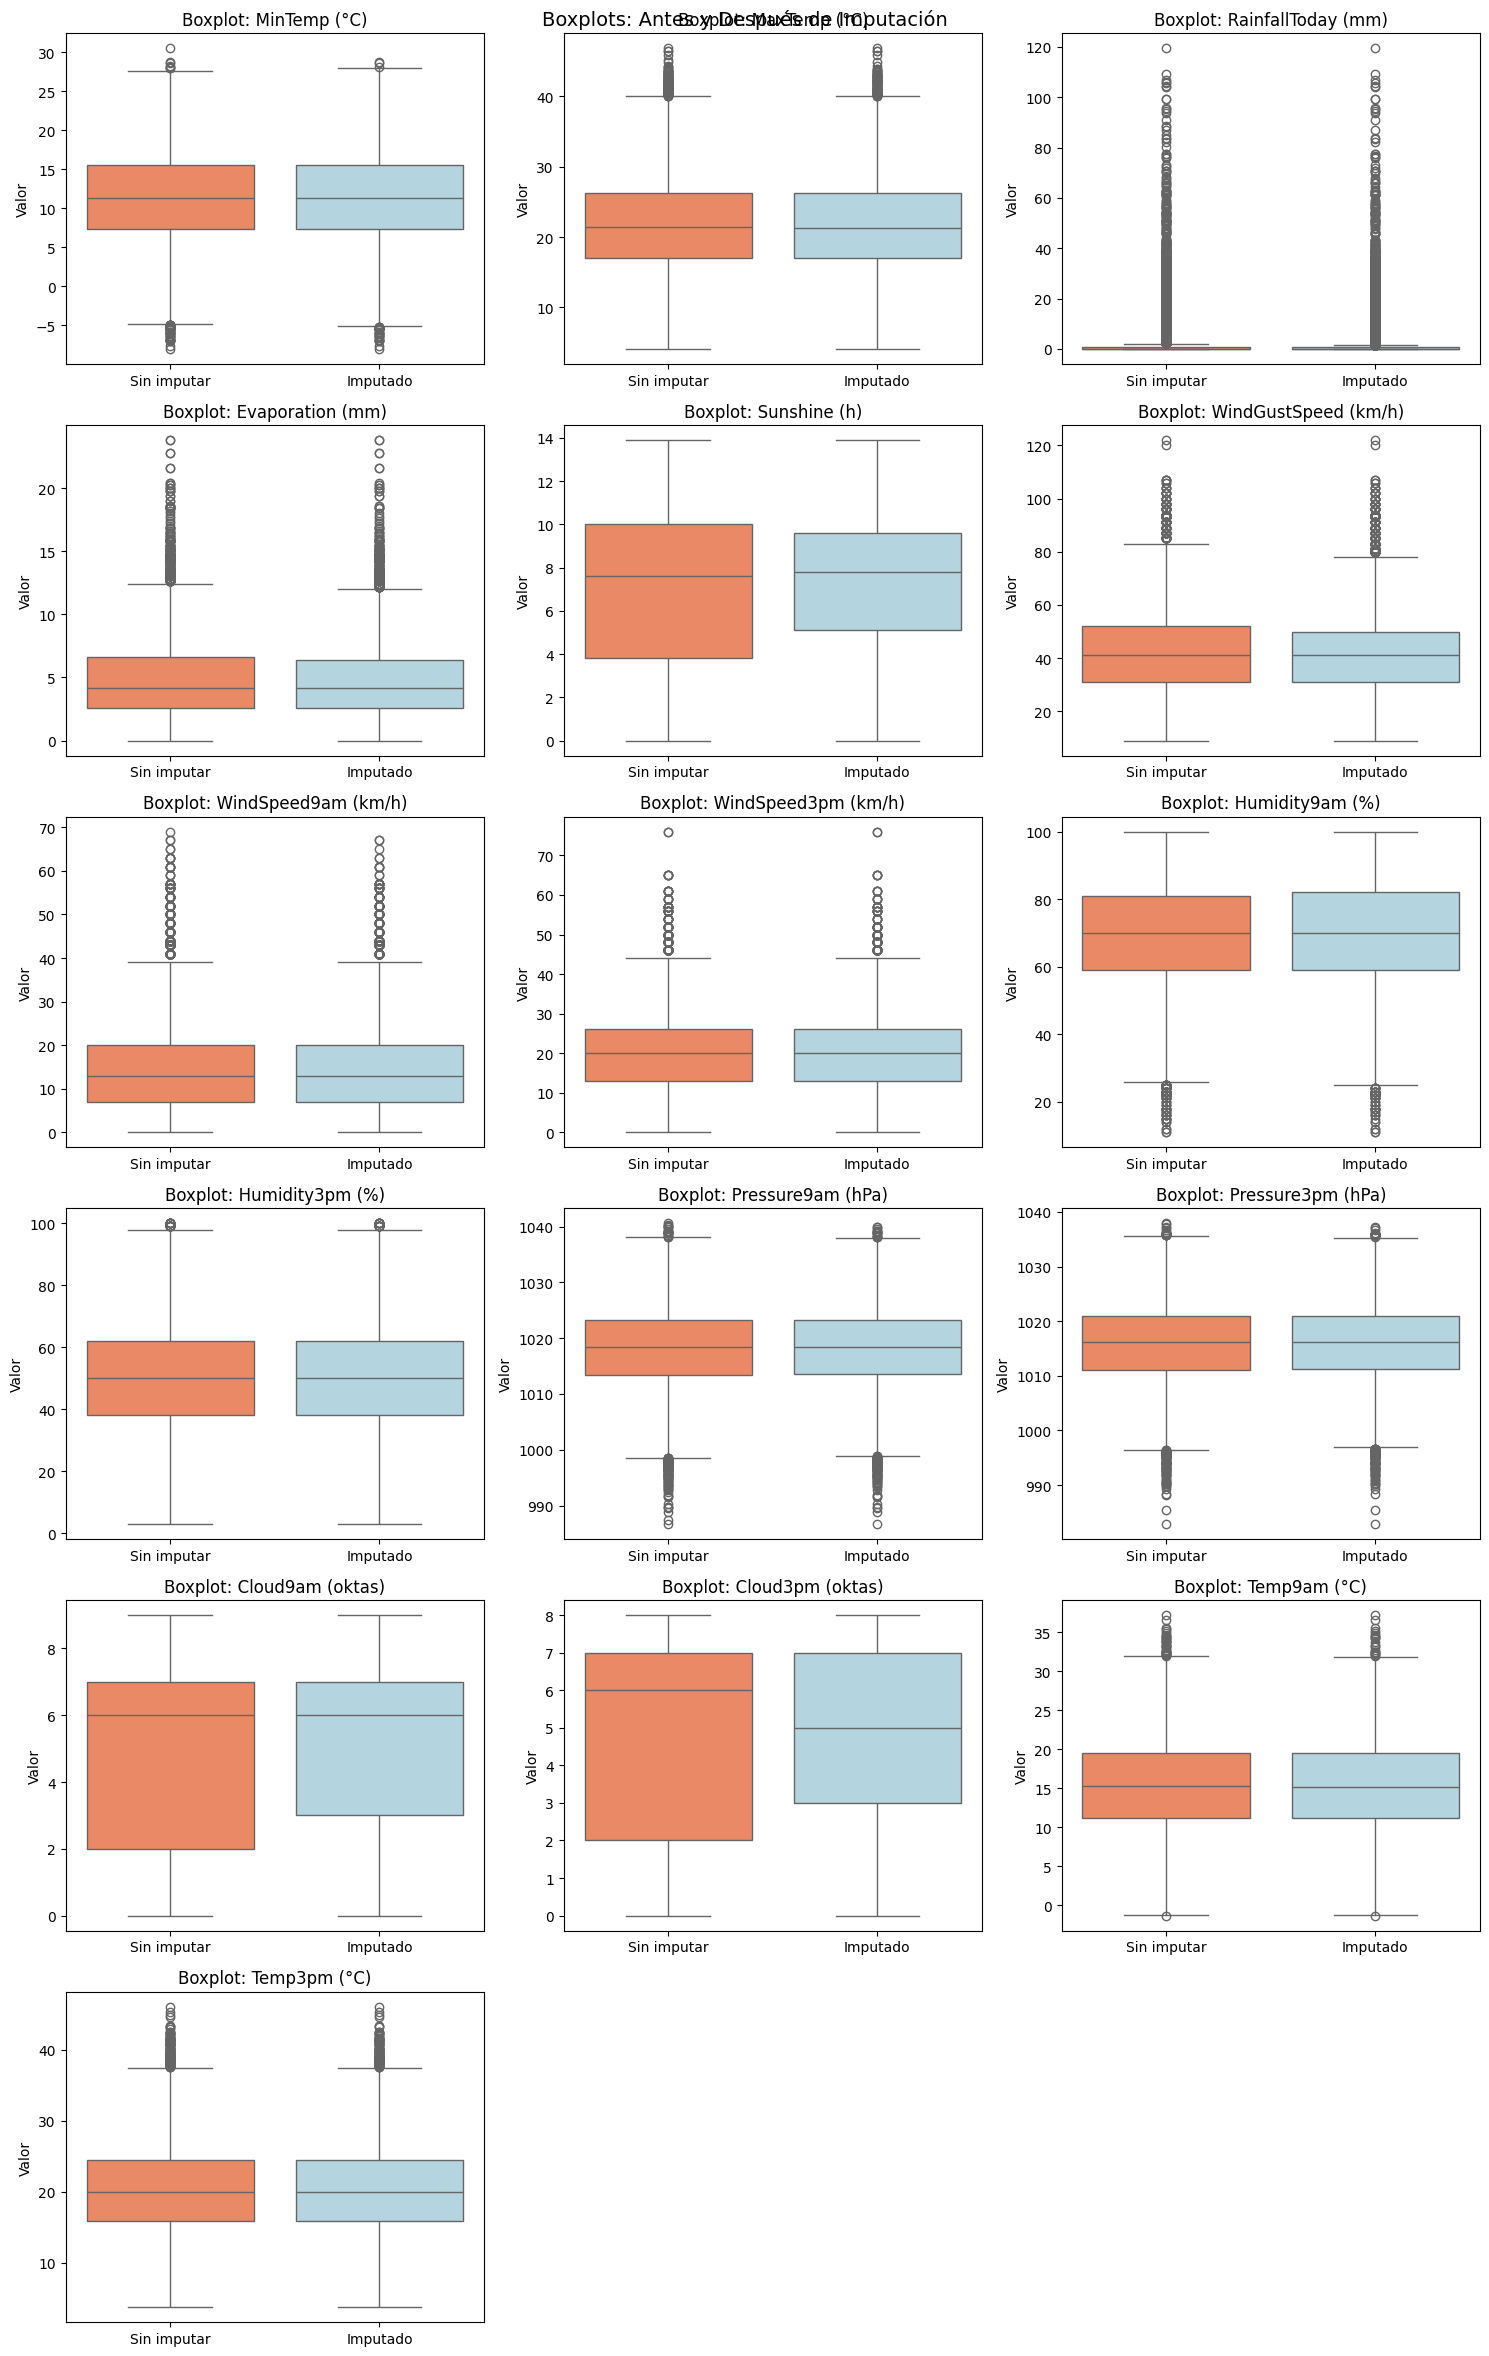

In [312]:
# ---- Boxplots: antes y después de imputación ----
# Los boxplots no se ven afectados por el tamaño del dataset
# ya que muestran mediana, cuartiles y outliers (valores relativos)
# por lo que no requieren normalización
fig, axes = plt.subplots(n_filas_imp, n_cols, figsize=(15, n_filas_imp * 4))
axes = axes.flatten()

for i, col in enumerate(cols_num_imp):
    temp_df = pd.concat([
        pd.DataFrame({col: df[col], 'Estado': 'Sin imputar'}),
        pd.DataFrame({col: X_train_val_imp[col], 'Estado': 'Imputado'})
    ]).reset_index(drop=True)

    sns.boxplot(data=temp_df, x='Estado', y=col, ax=axes[i],
                palette={'Sin imputar': 'coral', 'Imputado': 'lightblue'},
                hue='Estado', legend=False)
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Valor')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots: Antes y Después de Imputación', fontsize=14)
plt.tight_layout()
plt.show()

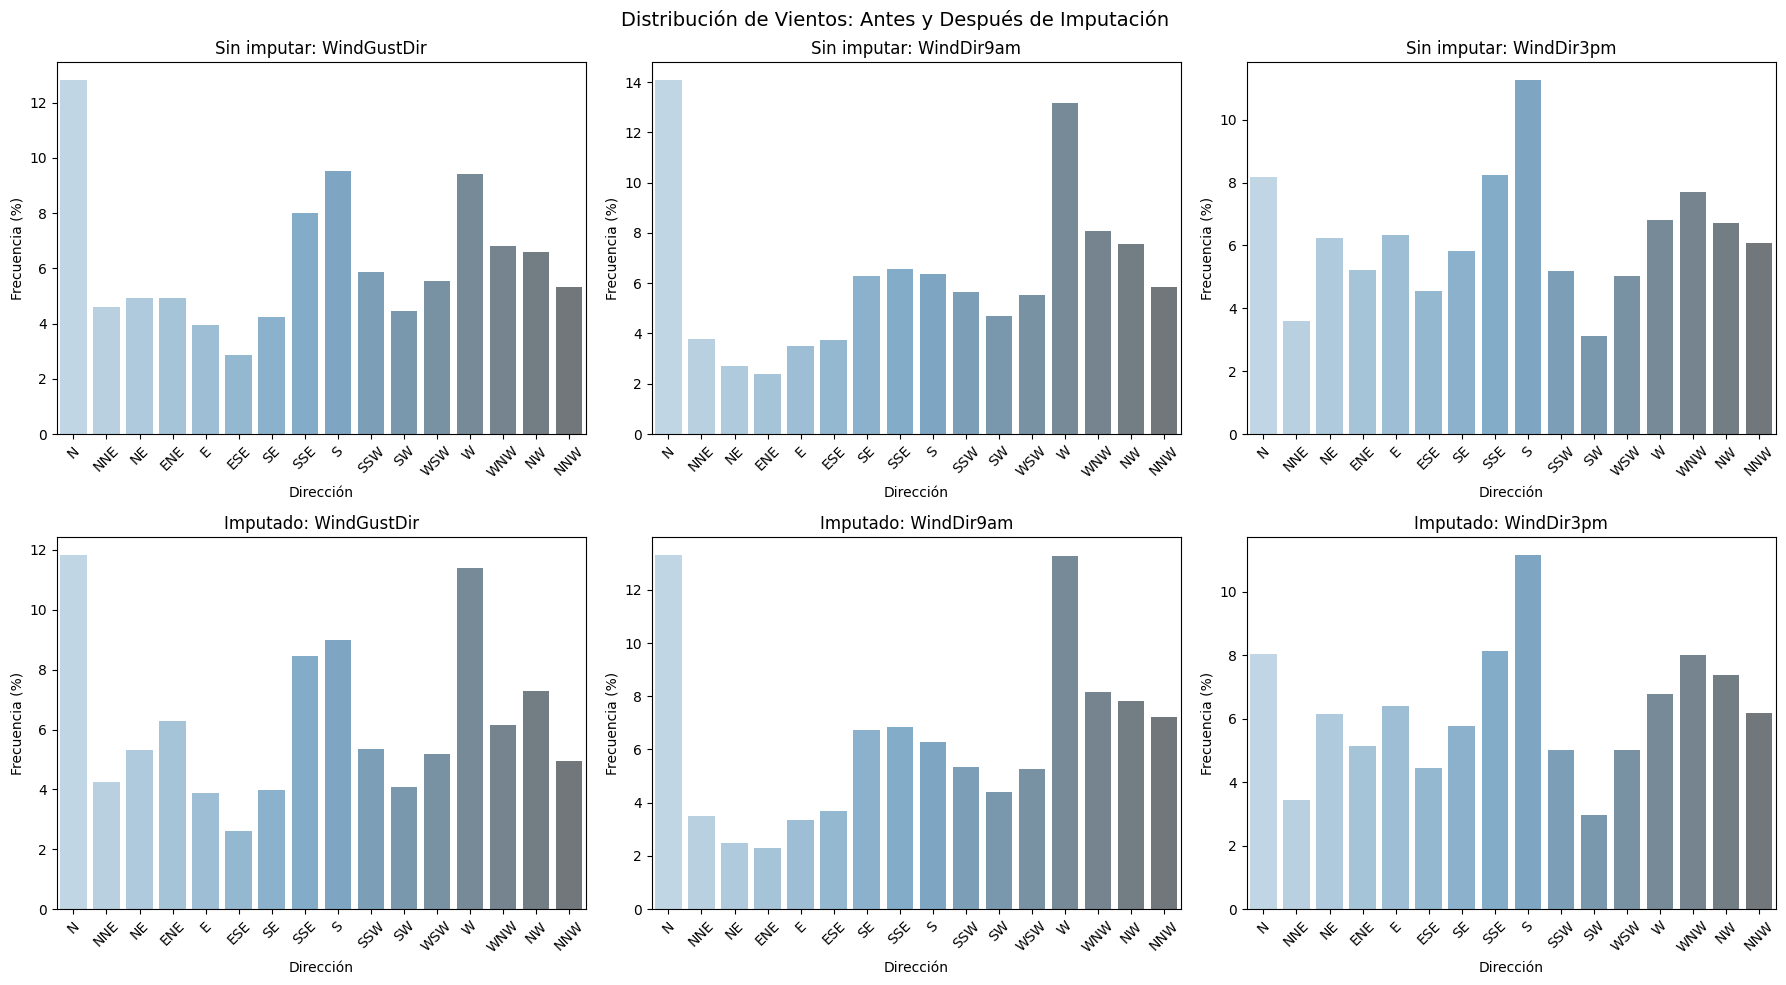

In [313]:
# Frecuencias de viento: antes y después de imputación
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, col in enumerate(wind_cols_orig):
    counts_before = df[col].value_counts(normalize=True).reindex(order) * 100
    counts_after  = X_train_val_imp[col].value_counts(normalize=True).reindex(order) * 100

    # Fila 1: Sin imputar
    sns.barplot(x=counts_before.index, y=counts_before.values, ax=axes[0, i], palette='Blues_d', alpha=0.7)
    axes[0, i].set_title(f'Sin imputar: {col}')
    axes[0, i].set_xlabel('Dirección')
    axes[0, i].set_ylabel('Frecuencia (%)')
    axes[0, i].tick_params(axis='x', rotation=45)

    # Fila 2: Imputado
    sns.barplot(x=counts_after.index, y=counts_after.values, ax=axes[1, i], palette='Blues_d', alpha=0.7)
    axes[1, i].set_title(f'Imputado: {col}')
    axes[1, i].set_xlabel('Dirección')
    axes[1, i].set_ylabel('Frecuencia (%)')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.suptitle('Distribución de Vientos: Antes y Después de Imputación', fontsize=14)
plt.tight_layout()
plt.show()

Luego de realizar la imputación de valores faltantes por mediana/moda agrupada por ciudad y mes, las distribuciones de las variables numéricas, los boxplots y las frecuencias de dirección de viento se mantienen prácticamente idénticos entre el conjunto sin imputar y el imputado. Esto confirma que la estrategia de imputación utilizada es no sesgada, ya que al imputar con estadísticos calculados a partir del propio conjunto de entrenamiento, los valores introducidos son consistentes con el comportamiento histórico de cada variable, preservando la forma de las distribuciones, la posición de la mediana, la dispersión y la proporción relativa de cada dirección de viento.

## Codificación

In [314]:
def transformar_dataset_final(df_imputed):
    df_res = df_imputed.copy()

    # Direcciones de Viento -> Codificación cíclica (Seno y Coseno)
    wind_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
    for col in wind_cols:
        # Conversión a radianes
        rads = df_res[col].map(wind_dir_map).astype(float) * (np.pi / 180)
        df_res[f'{col}_sin'] = np.sin(rads)
        df_res[f'{col}_cos'] = np.cos(rads)

    # Mes -> Codificaión cíclica (Seno y Coseno - base 12)
    month_rads = df_res['Month'].astype(float) * (2 * np.pi / 12)
    df_res['Month_sin'] = np.sin(month_rads)
    df_res['Month_cos'] = np.cos(month_rads)

    # RainToday -> Mapeo binario
    df_res['RainToday'] = df_res['RainToday'].map({'No': 0, 'Yes': 1})

    # Se eliminan Location y Month
    cols_to_drop = wind_cols + ['Month', 'Location']
    df_res = df_res.drop(columns=cols_to_drop)

    return df_res

# Aplicar la transformación a ambos conjuntos
X_train_val_cod = transformar_dataset_final(X_train_val_imp)
X_test_cod = transformar_dataset_final(X_test_imp)

# Target de clasificación -> No: 0 y Si: 1
y_train_val_class_cod = y_train_val_class.map({'No': 0, 'Yes': 1})
y_test_class = y_test_class.map({'No': 0, 'Yes': 1})

In [315]:
X_train_val_cod.head()

MinTemp (°C)  MaxTemp (°C)  RainfallToday (mm)  Evaporation (mm)  \
1802          13.1          31.4                 0.0               6.6   
1986           3.5          19.1                 0.0               3.0   
719           13.6          22.6                14.8               6.2   
9491           6.4          21.2                 0.0               2.8   
7034          15.8          27.7                 0.0               5.4   

      Sunshine (h)  WindGustSpeed (km/h)  WindSpeed9am (km/h)  \
1802          8.05                  20.0                  6.0   
1986          7.50                  15.0                  0.0   
719           8.45                  43.0                 20.0   
9491          7.90                  41.0                  9.0   
7034         10.50                  26.0                  9.0   

      WindSpeed3pm (km/h)  Humidity9am (%)  Humidity3pm (%)  ...  \
1802                  9.0             53.0             32.0  ...   
1986                  9.0             72.0             43.0  ...   
719                  22.0             69.0             51.0  ...   
9491                 22.0             76.0             41.0  ...   
7034                 13.0             69.0             43.0  ...   

      Temp3pm (°C)  RainToday  WindGustDir_sin  WindGustDir_cos  \
1802          29.9          0     1.224647e-16    -1.000000e+00   
1986          18.8          0     1.000000e+00     6.123234e-17   
719           21.7          1     3.826834e-01    -9.238795e-01   
9491          21.1          0     0.000000e+00     1.000000e+00   
7034          26.7          0     3.826834e-01    -9.238795e-01   

      WindDir9am_sin  WindDir9am_cos  WindDir3pm_sin  WindDir3pm_cos  \
1802        0.923880       -0.382683       -0.707107       -0.707107   
1986        0.707107       -0.707107        0.707107       -0.707107   
719         0.707107       -0.707107        0.707107       -0.707107   
9491        0.000000        1.000000        0.000000        1.000000   
7034        0.382683        0.923880        0.707107       -0.707107   

      Month_sin     Month_cos  
1802   0.866025  5.000000e-01  
1986  -0.866025 -5.000000e-01  
719   -0.500000  8.660254e-01  
9491  -1.000000 -1.836970e-16  
7034   1.000000  6.123234e-17  

[5 rows x 25 columns]

## Escalado

In [316]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val_cod)
X_test_scaled = scaler.transform(X_test_cod)

# Conversión a DataFrame para mantener los nombres de las columnas
X_train_val_scaled = pd.DataFrame(X_train_val_scaled, columns=X_train_val_cod.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_cod.columns)

## Split final train - val

In [317]:
# Split train - val
X_train, X_val, y_train_class, y_val_class, y_train_reg, y_val_reg = train_test_split(
    X_train_val_scaled,   # ya escalado
    y_train_val_class_cod,
    y_train_val_reg,
    test_size=0.2,
    random_state=42,
    stratify=y_train_val_class_cod
)

## Análisis de balanceo del dataset

--- Distribución de Clases en Entrenamiento ---
No llueve (0): 8981 muestras (77.08%)
Sí llueve (1): 2670 muestras (22.92%)


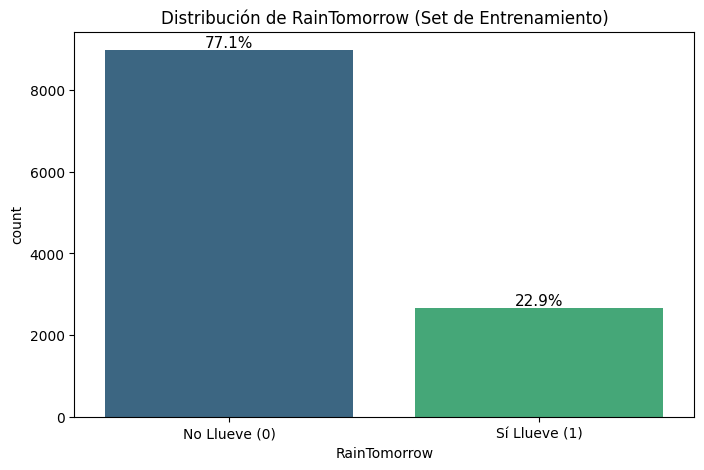

In [318]:
# Suponiendo que y_train_class_num es tu variable objetivo de entrenamiento
frecuencias = y_train_class.value_counts()
porcentajes = y_train_class.value_counts(normalize=True) * 100

print("--- Distribución de Clases en Entrenamiento ---")
print(f"No llueve (0): {frecuencias[0]} muestras ({porcentajes[0]:.2f}%)")
print(f"Sí llueve (1): {frecuencias[1]} muestras ({porcentajes[1]:.2f}%)")

plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_train_class, palette='viridis')
plt.title('Distribución de RainTomorrow (Set de Entrenamiento)')
plt.xticks(ticks=[0, 1], labels=['No Llueve (0)', 'Sí Llueve (1)'])

# Agregar etiquetas de porcentaje sobre las barras
for i, p in enumerate(ax.patches):
    ax.annotate(f'{porcentajes[i]:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

# **2. Modelo de regresión lineal múltiple**

## LinearRegression

In [319]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_reg)
y_pred_train = linear_model.predict(X_train)
y_pred_test  = linear_model.predict(X_test)

In [320]:
# Métricas del modelo
mae_train = mean_absolute_error(y_train_reg, y_pred_train)
mae_test  = mean_absolute_error(y_test_reg,  y_pred_test)
r2_train  = r2_score(y_train_reg, y_pred_train)
r2_test   = r2_score(y_test_reg,  y_pred_test)

print(f"{'Métrica':<10} {'Train':>10} {'Test':>10}")
print(f"{'-'*32}")
print(f"{'MAE':<10} {mae_train:>10.2f} {mae_test:>10.2f}")
print(f"{'R²':<10} {r2_train:>10.2f} {r2_test:>10.2f}")

Métrica         Train       Test
--------------------------------
MAE              3.09       3.01
R²               0.22       0.25


Se eligieron MAE y R² como métricas de evaluación. El MAE expresa el error promedio en las mismas unidades que la variable objetivo (milímetros de lluvia) y, a diferencia del RMSE, es robusto frente a outliers ya que trata todos los errores de forma lineal, lo que es adecuado dada la distribución sesgada de la lluvia con valores extremos. El R² indica qué proporción de la varianza del target explica el modelo.

Se calculan para ambos conjuntos para poder diagnosticar el comportamiento real del modelo (si tiene un ajuste adecuado o presenta overfitting o underfitting).

En este caso el modelo obtuvo un MAE de 3.09 mm en train y 3.01 mm en test, con R² de 0.22 y 0.25 respectivamente. Los valores prácticamente idénticos entre ambos conjuntos confirman ausencia de overfitting. Sin embargo, el R² bajo evidencia underfitting: el modelo solo explica el 25% de la varianza de la lluvia, lo cual es esperable dado que la regresión lineal no logra capturar las relaciones no lineales propias del fenómeno meteorológico.


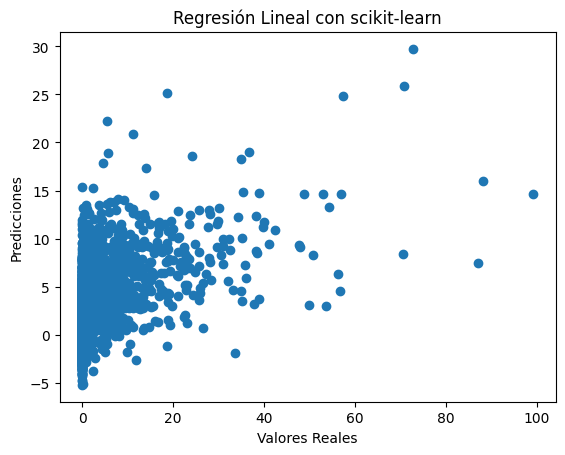

In [321]:
plt.scatter(y_test_reg, y_pred_test)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Regresión Lineal con scikit-learn")
plt.show()

Las predicciones se concentran en un rango muy estrecho (≈ -5 a 30 mm) sin importar cuánto llueva en realidad, lo que confirma que el modelo no captura los eventos extremos. Para valores reales de 60-100 mm, el modelo sigue prediciendo ~10-15 mm.

In [322]:
def resPlot(modelo, nombre_modelo, x_test, y_test):
    pred = modelo.predict(x_test)

    if hasattr(y_test, 'values'):
        y_test_array = y_test.values.ravel()
    else:
        y_test_array = y_test.ravel()

    pred = pred.ravel()

    plt.figure(figsize=(5,3))
    plt.scatter(pred, y_test_array - pred, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.title(f"Residuos - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Residuo")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'Residuos porcentuales - {nombre_modelo}')
    plt.xlabel('Valores de test')
    plt.ylabel('Residuos (%)')

    percentage_residuals = np.where(y_test_array != 0,
                                   100 * (y_test_array - pred) / y_test_array, 0)
    plt.scatter(y_test_array, percentage_residuals, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.show()

    return

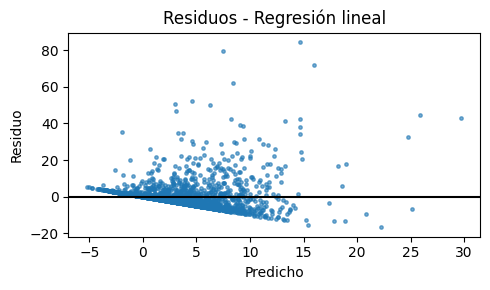

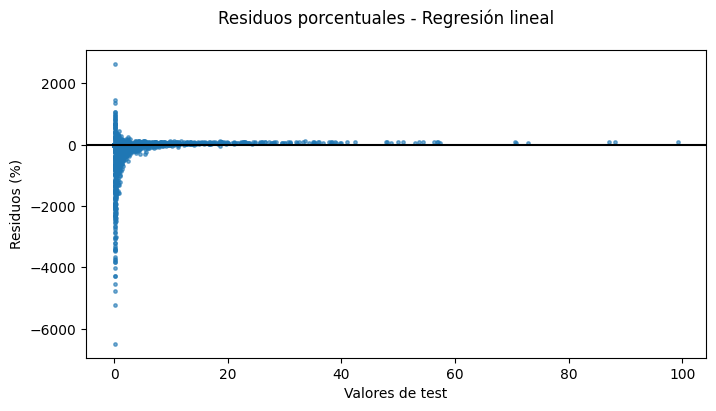

In [323]:
resPlot(linear_model, 'Regresión lineal', X_test, y_test_reg)

El gráfico de residuos indica que el error aumenta a medida que aumentan las predicciones. Los residuos no están distribuidos aleatoriamente alrededor del cero.
El gráfico de residuos porcentuales indica que para valores mayores a 20 mm los residuos se estabilizan, lo que sugiere que el modelo funciona relativamente mejor en días con lluvia moderada-alta que en días sin lluvia o con lluvia mínima.

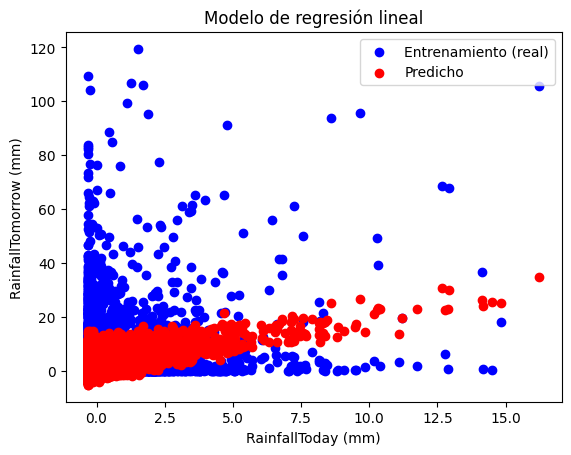

In [324]:
plt.scatter(X_train['RainfallToday (mm)'], y_train_reg, color='blue',label='Entrenamiento (real)')
plt.scatter(X_train['RainfallToday (mm)'], linear_model.predict(X_train), color='red',label='Predicho')

plt.xlabel('RainfallToday (mm)')
plt.ylabel('RainfallTomorrow (mm)')
plt.legend()
plt.title('Modelo de regresión lineal')

plt.show()

El gráfico muestra que para un mismo valor de RainfallToday, la lluvia del día siguiente puede variar mucho, evidenciando que la relación entre ambas variables no es lineal. Las predicciones del modelo predicho indica que está prediciendo la media de la lluvia en lugar de capturar la variabilidad real. Esto confirma visualmente el underfitting detectado en las métricas, que una relación lineal no es suficiente para representar la complejidad del fenómeno meteorológico.

## Gradiente descendiente

In [335]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, tol=1e-6, patience=10):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, tol=1e-6, patience=10):
    n = X_train.shape[0]
    m = X_train.shape[1]

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j] # Shape (m+1,)
            y_sample = y_train[j] # Shape (1,)

            prediction = np.dot(x_sample, W)
            error = y_sample - prediction # (1,) - scalar -> (1,)
            train_mse = error ** 2
            train_errors.append(train_mse[0])

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)



    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (SGD)')
    plt.show()

    return W

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32, tol=1e-6, patience=10):
    n = X_train.shape[0]
    m = X_train.shape[1]

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size, :]

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

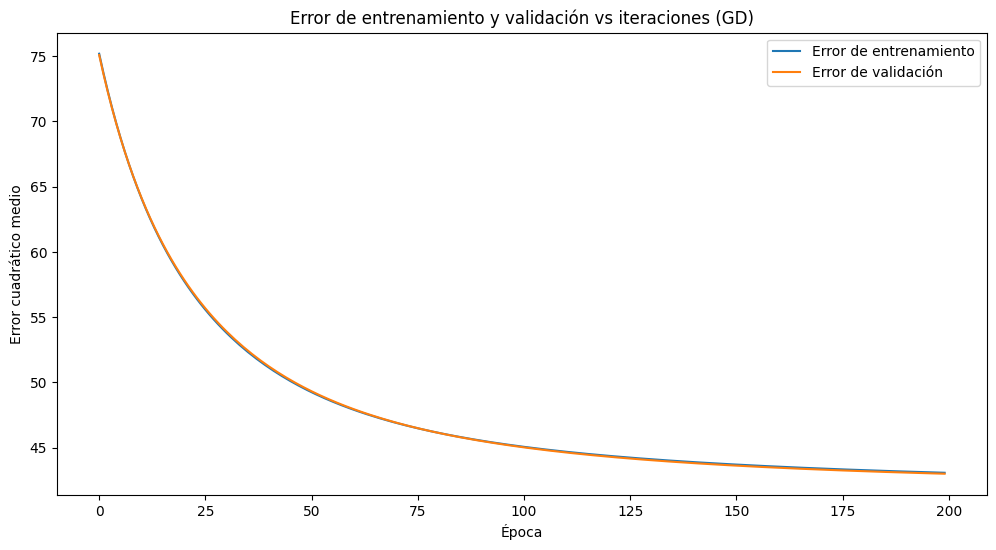

array([[ 2.18767732e+00],
       [ 9.34933897e-02],
       [-1.66172151e-02],
       [ 1.30150940e+00],
       [ 3.48022780e-02],
       [-7.59109465e-01],
       [ 6.59635210e-01],
       [-3.10560669e-01],
       [ 2.86777987e-01],
       [ 1.50702859e-01],
       [ 1.84041336e+00],
       [-5.27515583e-02],
       [-4.47708995e-01],
       [-1.67417562e-01],
       [ 2.70031228e-01],
       [ 6.12396435e-01],
       [ 3.83785297e-01],
       [-1.06667277e-01],
       [ 8.30257982e-02],
       [ 9.22196218e-04],
       [ 4.32930865e-01],
       [-2.99930337e-01],
       [-2.90978684e-02],
       [ 2.18534182e-02],
       [-3.21590013e-01],
       [-5.32313052e-01]])

In [336]:
gradient_descent(X_train.values,
    y_train_reg.values,
    X_val.values,
    y_val_reg.values,
    lr=0.010,
    epochs=200
)

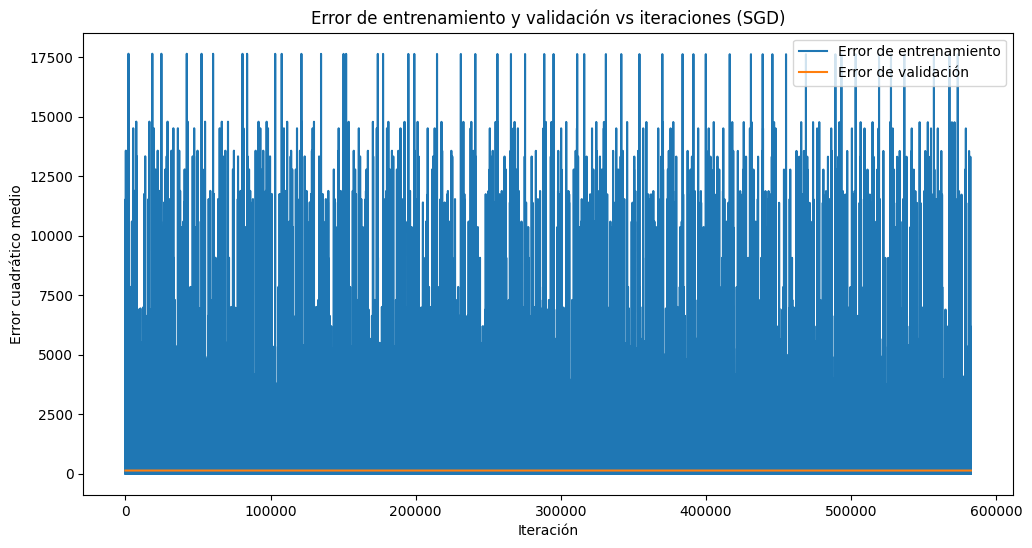

array([[-1.32348762],
       [ 0.0526846 ],
       [ 2.16272201],
       [-1.64382545],
       [-0.70400191],
       [ 0.05087706],
       [-0.69902455],
       [ 0.59918866],
       [-2.31937099],
       [ 2.80425508],
       [ 0.24030498],
       [ 2.53727044],
       [ 0.5876437 ],
       [ 0.93420548],
       [-0.43302328],
       [-0.90715646],
       [ 1.21106373],
       [ 0.1529269 ],
       [-0.1122843 ],
       [-1.54081566],
       [-0.47401216],
       [-0.69690208],
       [-1.00215821],
       [-2.34145006],
       [-1.17280256],
       [-0.86334881]])

In [327]:
stochastic_gradient_descent(X_train.values, y_train_reg.values, X_val.values, y_val_reg.values, lr=1e-9, epochs=50)

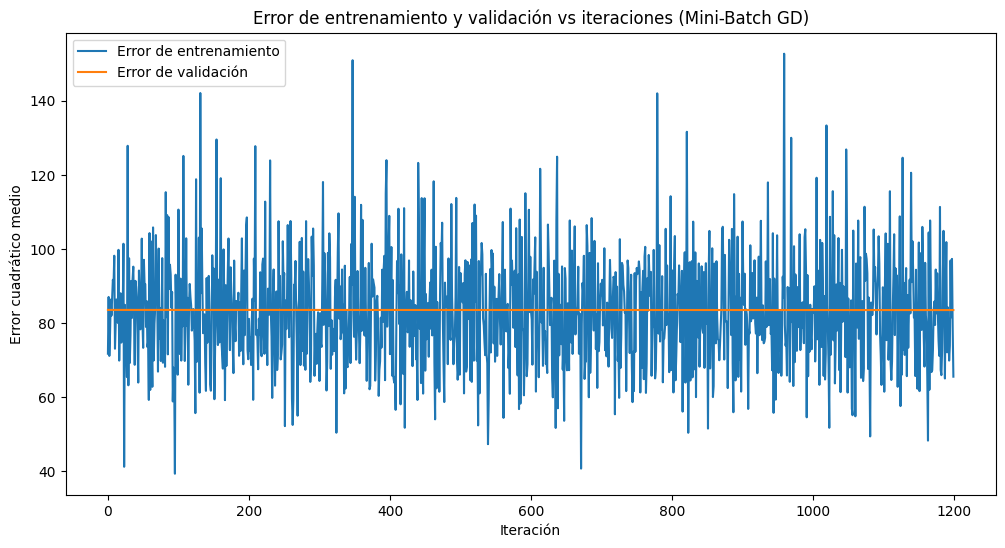

array([[-1.15677604],
       [ 0.01703683],
       [ 0.21168994],
       [ 0.68036152],
       [ 1.25718353],
       [-0.70440791],
       [-1.01511068],
       [-1.19835641],
       [ 1.67602738],
       [ 1.3824233 ],
       [ 0.12709603],
       [ 0.4015366 ],
       [ 0.07415274],
       [-0.94963799],
       [-0.98057934],
       [-0.52469868],
       [ 2.43835852],
       [ 0.46328352],
       [-1.61648049],
       [-1.10957948],
       [ 0.59005348],
       [-0.73413734],
       [ 0.64027625],
       [ 0.5831692 ],
       [-1.31577673],
       [ 0.92796698]])

In [328]:
mini_batch_gradient_descent(X_train.values, y_train_reg.values, X_val.values, y_val_reg.values, lr=1e-7, epochs=100, batch_size=1024)

El GD clásico converge de forma suave y estable en ambas curvas, alcanzando un MSE de 43 sin señales de overfitting. El SGD presenta una varianza extremadamente alta debido a que actualiza con un solo dato por vez, siendo muy sensible a los outliers de lluvia del dataset. El Mini-Batch GD representa un punto intermedio, donde la varianza se reduce considerablemente respecto al SGD pero los picos persisten, oscilando alrededor del error de validación (90). En los tres casos el error de validación permanece estable y por debajo del de entrenamiento, lo que confirma ausencia de overfitting.



## Regularización

In [341]:
alpha_val = 0.1

lasso = Lasso(alpha=alpha_val)
ridge = Ridge(alpha=alpha_val)
elasticnet = ElasticNet(alpha=alpha_val, l1_ratio=0.5)

lasso.fit(X_train, y_train_reg)
ridge.fit(X_train, y_train_reg)
elasticnet.fit(X_train, y_train_reg)

# Métricas
for nombre, modelo in [('Lasso', lasso), ('Ridge', ridge), ('ElasticNet', elasticnet)]:
    mae = mean_absolute_error(y_test_reg, modelo.predict(X_test))
    r2  = r2_score(y_test_reg, modelo.predict(X_test))
    print(f"{nombre} → MAE: {mae:.4f} | R²: {r2:.4f}")

Lasso → MAE: 2.9371 | R²: 0.2309
Ridge → MAE: 3.0051 | R²: 0.2462
ElasticNet → MAE: 2.9206 | R²: 0.2338


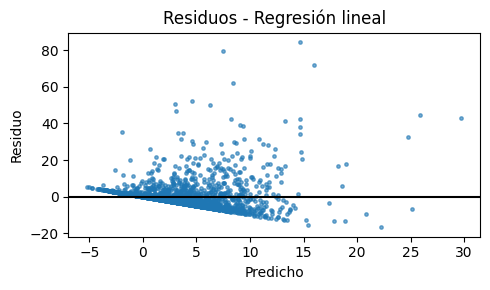

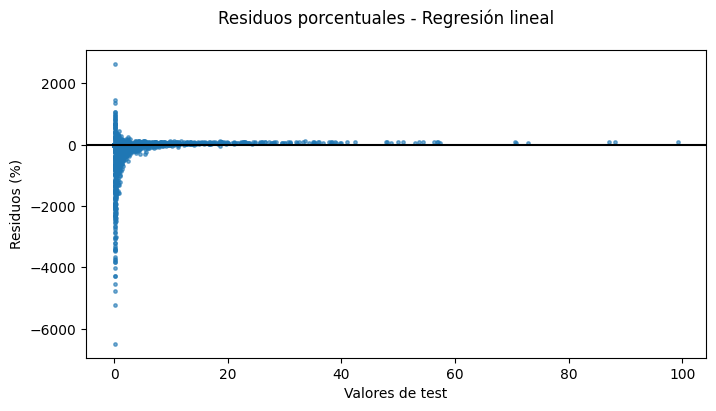

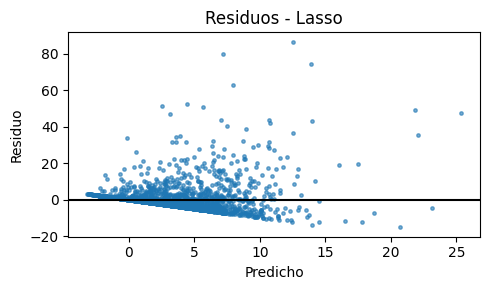

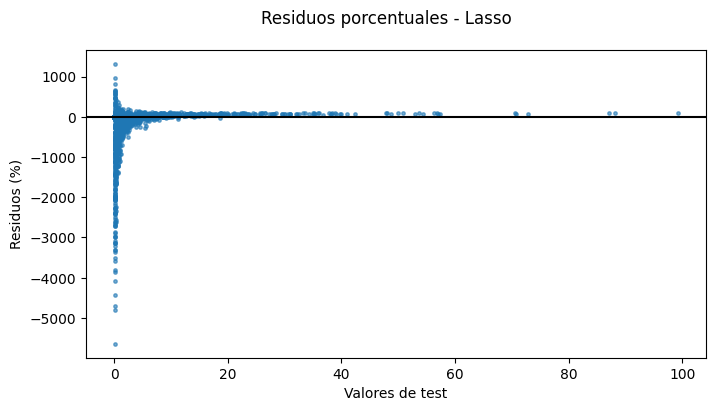

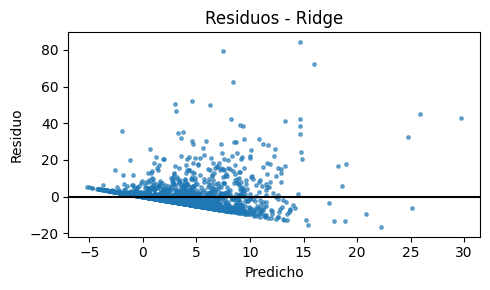

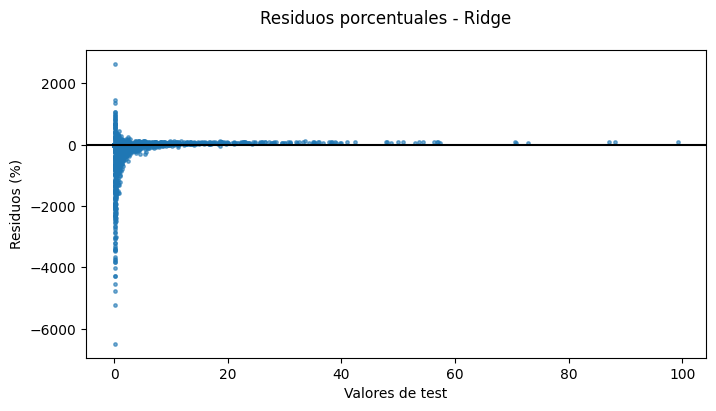

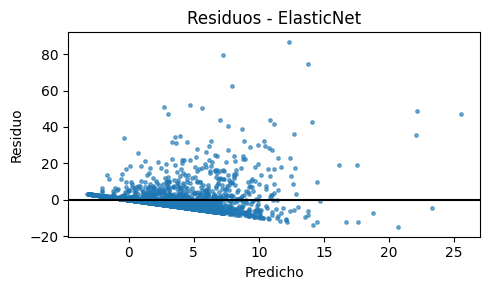

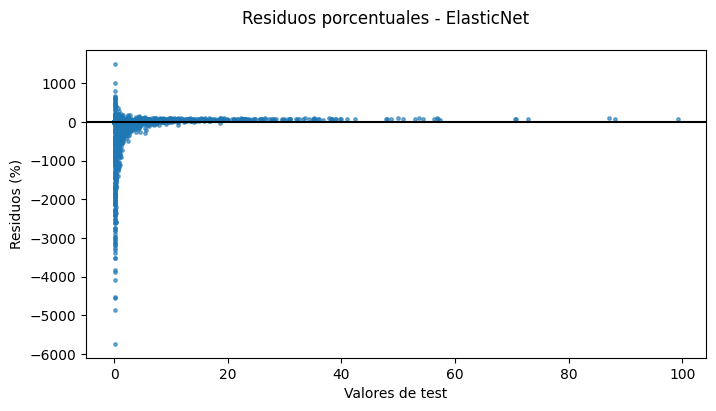

In [342]:
resPlot(linear_model, 'Regresión lineal', X_test, y_test_reg)
resPlot(lasso, 'Lasso', X_test, y_test_reg)
resPlot(ridge, 'Ridge', X_test, y_test_reg)
resPlot(elasticnet, 'ElasticNet', X_test, y_test_reg)

Los tres métodos de reglarización presentan patrones de residuos prácticamente idénticos al de regresión lineal, lo que confirma que la regularización no introduce mejoras significativas. En el gráfico de residuos vs. predicho se observa que la varianza de los errores crece con el valor predicho, y el modelo sobreestima valores bajos y subestima valores altos. En cuanto a los residuos porcentuales, la dispersión extrema para valores reales cercanos a cero se debe matemáticamente a la división por valores muy pequeños, mientras que para lluvias mayores a 20 mm los residuos se estabilizan cerca del cero.

ElasticNet obtiene el menor MAE (2.92 mm) y Ridge el mayor R² (0.25), pero la brecha entre todos muy pequeña. Esto evidencia que el problema no es el overfitting sino underfitting, ya que la lluvia sigue una distribución que los modelos lineales no pueden capturar independientemente de la regularización aplicada.

# **3. Modelo de clasificación binaria**

## LogisticRegression con class_weight='balanced'

In [344]:
# Modelo con pesos balanceados
model_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model_balanced.fit(X_train, y_train_class)

# Predicción
y_pred_bal = model_balanced.predict(X_test)

print("\n--- Reporte de Clasificación: Pesos Balanceados ---")
print(classification_report(y_test_class, y_pred_bal))


--- Reporte de Clasificación: Pesos Balanceados ---
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2807
           1       0.52      0.76      0.62       835

    accuracy                           0.78      3642
   macro avg       0.72      0.78      0.73      3642
weighted avg       0.83      0.78      0.80      3642



## LogisticRegression con SMOTE

In [346]:
# 1. Aplicar SMOTE únicamente al set de ENTRENAMIENTO
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train_class)

print(f"\nDistribución original: {Counter(y_train_class)}")
print(f"Distribución tras SMOTE: {Counter(y_train_smote)}")

# 2. Entrenar una Regresión Logística estándar sobre los datos aumentados
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)

# 3. Predicción (siempre sobre el X_test original)
y_pred_smote = model_smote.predict(X_test)

print("\n--- Reporte de Clasificación: SMOTE ---")
print(classification_report(y_test_class, y_pred_smote))


Distribución original: Counter({0: 8981, 1: 2670})
Distribución tras SMOTE: Counter({0: 8981, 1: 8981})

--- Reporte de Clasificación: SMOTE ---
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2807
           1       0.52      0.77      0.62       835

    accuracy                           0.78      3642
   macro avg       0.72      0.78      0.73      3642
weighted avg       0.83      0.78      0.79      3642



## Comparación de métodos de balanceo

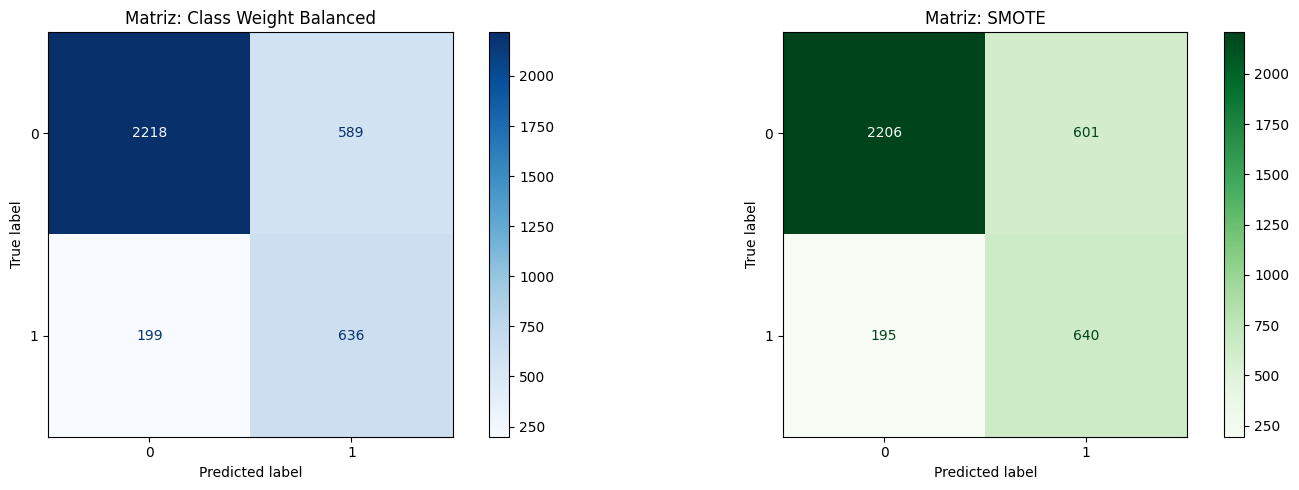

In [348]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Matriz para Pesos Balanceados
ConfusionMatrixDisplay.from_predictions(y_test_class, y_pred_bal,
                                        cmap='Blues', ax=ax[0])
ax[0].set_title('Matriz: Class Weight Balanced')

# Matriz para SMOTE
ConfusionMatrixDisplay.from_predictions(y_test_class, y_pred_smote,
                                        cmap='Greens', ax=ax[1])
ax[1].set_title('Matriz: SMOTE')

plt.tight_layout()
plt.show()

Ambos métodos de balanceo obtienen resultados muy parecidos tanto en métricas como en las matrices de confusión. Se prefiere seguir con SMOTE dado que al generar ejemplos interpolando entre instancias reales puede favorecer una mejor generalización en modelos más complejos aplicados posteriormente.

## Curvas ROC

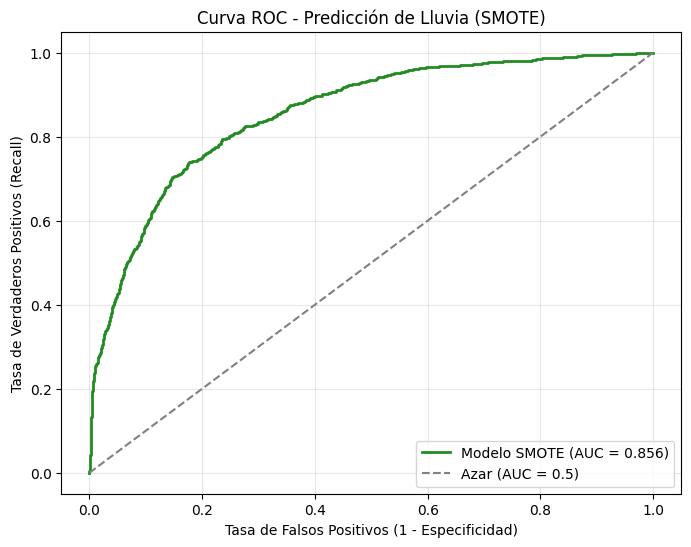

In [350]:
# Probabilidades de la clase positiva (1: Sí llueve)
y_probs_smote = model_smote.predict_proba(X_test)[:, 1]

# FPR, TPR y Umbrales para la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test_class, y_probs_smote)
auc_val = roc_auc_score(y_test_class, y_probs_smote)

# Gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='forestgreen', lw=2, label=f'Modelo SMOTE (AUC = {auc_val:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Azar (AUC = 0.5)')
plt.title('Curva ROC - Predicción de Lluvia (SMOTE)')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [351]:
# Predicciones para ambos conjuntos
y_pred_train = model_smote.predict(X_train_smote) # Datos balanceados
y_pred_test = model_smote.predict(X_test)

print("--- REPORTE ENTRENAMIENTO (SMOTE) ---")
print(classification_report(y_train_smote, y_pred_train))

print("\n--- REPORTE TEST (REAL) ---")
print(classification_report(y_test_class, y_pred_test))

--- REPORTE ENTRENAMIENTO (SMOTE) ---
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      8981
           1       0.78      0.76      0.77      8981

    accuracy                           0.77     17962
   macro avg       0.77      0.77      0.77     17962
weighted avg       0.77      0.77      0.77     17962


--- REPORTE TEST (REAL) ---
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2807
           1       0.52      0.77      0.62       835

    accuracy                           0.78      3642
   macro avg       0.72      0.78      0.73      3642
weighted avg       0.83      0.78      0.79      3642



In [353]:
# OPTIMIZACIÓN DE UMBRAL EN CONJUNTO DE VALIDACIÓN
print("\n" + "="*60)
print("OPTIMIZANDO UMBRAL EN CONJUNTO DE VALIDACIÓN")
print("="*60)

# Generar probabilidades en VALIDACIÓN (usando el set que separamos recién)
y_proba_valid = model_smote.predict_proba(X_val)[:, 1]

# Generar thresholds desde la curva ROC de VALIDACIÓN
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_val_class, y_proba_valid)

# Encontrar umbral óptimo usando VALIDACIÓN
f1_scores_valid = []
for thresh in thresholds_valid:
    y_pred_thresh = (y_proba_valid >= thresh).astype(int)
    f1_scores_valid.append(f1_score(y_val_class, y_pred_thresh))

optimal_idx = np.argmax(f1_scores_valid)
optimal_threshold = thresholds_valid[optimal_idx]
best_f1_valid = f1_scores_valid[optimal_idx]

print(f"\nÓptimo umbral (maximizando F1 en validación): {optimal_threshold:.4f}")
print(f"F1-score en validación con umbral óptimo: {best_f1_valid:.4f}")

# Evalua en TEST con el umbral encontrado en validación
print("\n" + "="*60)
print("EVALUACIÓN EN CONJUNTO DE TEST FINAL")
print("="*60)

y_proba_test = model_smote.predict_proba(X_test)[:, 1]
y_pred_optimal_test = (y_proba_test >= optimal_threshold).astype(int)
y_pred_05_test = (y_proba_test >= 0.5).astype(int)

print(f"\nMétricas en TEST con umbral 0.5:")
print(f"  F1-score: {f1_score(y_test_class, y_pred_05_test):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_class, y_pred_05_test):.4f}")
print(f"  Precision: {precision_score(y_test_class, y_pred_05_test):.4f}")
print(f"  Recall: {recall_score(y_test_class, y_pred_05_test):.4f}")

print(f"\nMétricas en TEST con umbral óptimo ({optimal_threshold:.4f}):")
print(f"  F1-score: {f1_score(y_test_class, y_pred_optimal_test):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_class, y_pred_optimal_test):.4f}")
print(f"  Precision: {precision_score(y_test_class, y_pred_optimal_test):.4f}")
print(f"  Recall: {recall_score(y_test_class, y_pred_optimal_test):.4f}")


OPTIMIZANDO UMBRAL EN CONJUNTO DE VALIDACIÓN

Óptimo umbral (maximizando F1 en validación): 0.5530
F1-score en validación con umbral óptimo: 0.6278

EVALUACIÓN EN CONJUNTO DE TEST FINAL

Métricas en TEST con umbral 0.5:
  F1-score: 0.6166
  Accuracy: 0.7814
  Precision: 0.5157
  Recall: 0.7665

Métricas en TEST con umbral óptimo (0.5530):
  F1-score: 0.6331
  Accuracy: 0.8040
  Precision: 0.5545
  Recall: 0.7377


Con un AUC de 0.856 el modelo discrimina bien entre días lluviosos y no lluviosos, superando ampliamente al clasificador aleatorio.

Respecto al umbral, el óptimo encontrado fue 0.553, levemente por encima del default de 0.5. Con un umbral 0.5, se obtiene mayor recall (0.77) pero menor precisión (0.52), es decir, detecta más días lluviosos pero genera más falsas alarmas. Con un umbral 0.553, se obtiene mejor balance entre precisión (0.55) y recall (0.74), logrando un F1 de 0.633 y una accuracy de 0.80.
En un contexto meteorológico, el umbral óptimo es preferible ya que mejora la precisión sin sacrificar demasiado el recall, reduciendo las falsas alarmas. 

La brecha entre las métricas de entrenamiento (accuracy ~0.77 balanceado) y test (accuracy ~0.80 real) confirma la ausencia de overfitting.

# **4. Red neuronal**

## Regresión

In [359]:
class RedNeuronalRegresora:
    def __init__(self, épocas=100, batch_size=32, learning_rate=0.001, dropout_rate=0.2):
        self.épocas = épocas
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self, input_shape):
        # Arquitectura: 2 capas ocultas con Dropout para evitar overfitting
        model = models.Sequential([
            layers.Input(shape=(input_shape,)),
            layers.Dense(64, activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Dense(32, activation='relu'),
            layers.Dropout(self.dropout_rate),
            # Capa de salida: 1 neurona con activación lineal (o relu si la lluvia no puede ser < 0)
            layers.Dense(1, activation='relu')
        ])

        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        # Compilación para regresión: loss='mse'
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        # Entrenamiento
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=self.épocas,
            batch_size=self.batch_size,
            verbose=1
        )
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        loss, mae = self.model.evaluate(X_test, y_test)
        y_pred = self.model.predict(X_test).flatten()
        r2 = r2_score(y_test, y_pred)
        print(f"\n--- MÉTRICAS RED NEURONAL (Regresión) ---")
        print(f"Test MSE: {loss:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R²:  {r2:.4f}")

    def predict(self, X_new):
        return self.model.predict(X_new)

In [360]:
# Instancia la red con hiperparámetros
nn_regresion = RedNeuronalRegresora(épocas=100, batch_size=64, learning_rate=0.001)

# Construye el modelo basado en la cantidad de columnas de X
nn_regresion.build_model(input_shape=X_train.shape[1])

# Entrenamiento con validación
history_loss, history_val_loss = nn_regresion.train(
    X_train, y_train_reg,
    X_val, y_val_reg      
)

# Evalua en el conjunto de Test
nn_regresion.evaluate(X_test, y_test_reg)

Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 46.1446 - mae: 2.6795 - val_loss: 41.5135 - val_mae: 2.4685
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 41.3548 - mae: 2.4322 - val_loss: 39.3689 - val_mae: 2.2480
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 40.1939 - mae: 2.4078 - val_loss: 38.5937 - val_mae: 2.0937
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 39.3716 - mae: 2.3776 - val_loss: 37.3954 - val_mae: 2.2069
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 38.0328 - mae: 2.3268 - val_loss: 37.0596 - val_mae: 2.2347
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 37.7860 - mae: 2.3255 - val_loss: 36.4098 - val_mae: 2.3082
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.7006 - mae: 2.3216 - val_loss: 36.4123 - val_mae: 2.1850
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.8125 - mae: 2.3182 - val_loss: 36.0270 - val_mae: 2.3416
Epoch 9/100
183/183 ━━━━━━━━━━━━

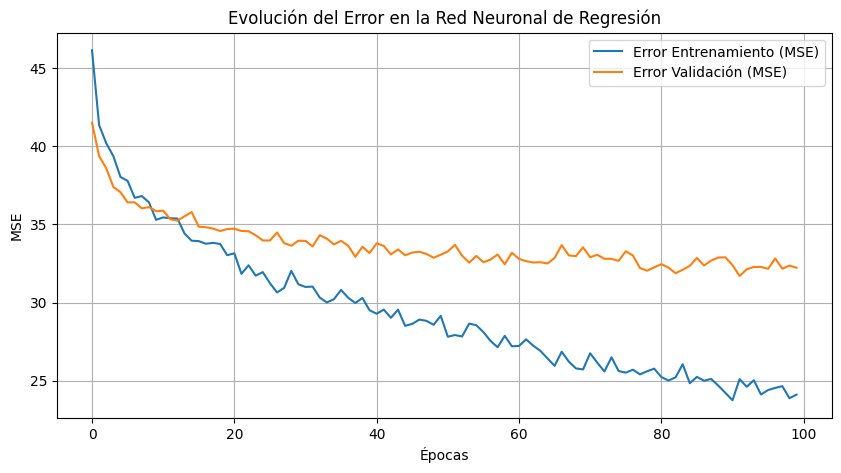

In [361]:
plt.figure(figsize=(10, 5))
plt.plot(history_loss, label='Error Entrenamiento (MSE)')
plt.plot(history_val_loss, label='Error Validación (MSE)')
plt.title('Evolución del Error en la Red Neuronal de Regresión')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

La red neuronal de regresión logra la mejor performance entre todos los modelos evaluados, con un MAE de 2.10mm y R² de 0.37, superando a los modelos lineales gracias a su capacidad de capturar relaciones no lineales. En el gráfico se observa que ambas curvas convergen rápidamente, aunque a partir de la época 20 aparece una brecha creciente entre entrenamiento (24 MSE) y validación (32 MSE), indicando un overfitting moderado que el Dropout mitiga pero no elimina completamente. El R² moderado era esperable dado que la lluvia es un fenómeno con alta variabilidad aleatoria difícil de capturar incluso con modelos más complejos.

## Clasificación binaria

In [362]:
class RedNeuronalClasificadora:
    def __init__(self, épocas=100, batch_size=32, learning_rate=0.001, dropout_rate=0.2):
        self.épocas = épocas
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self, input_shape):
        model = models.Sequential([
            layers.Input(shape=(input_shape,)),
            layers.Dense(64, activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Dense(32, activation='relu'),
            layers.Dropout(self.dropout_rate),
            # Capa de salida binaria: 1 neurona con sigmoide
            layers.Dense(1, activation='sigmoid')
        ])

        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        # Compilación para clasificación binaria
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        self.model = model

    def train(self, X_train, y_train, X_valid, y_valid):
        # Entrenamiento usando los datos balanceados (SMOTE) para evitar sesgos
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=self.épocas,
            batch_size=self.batch_size,
            verbose=1
        )
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [ ]:
# Instancia el modelo y construye
nn_clasificacion = RedNeuronalClasificadora(épocas=100, batch_size=64, learning_rate=0.001)
nn_clasificacion.build_model(input_shape=X_train.shape[1])

# Entrenamiento
history_loss, history_val_loss = nn_clasificacion.train(
    X_train_smote, y_train_smote,
    X_val, y_val_class
)

# Probabilidades en el conjunto de validación para optimizar umbral
y_probs_val_nn = nn_clasificacion.model.predict(X_val).flatten()

# Buscar el mejor umbral (el que maximice F1)
umbrales = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_val_class, (y_probs_val_nn >= t).astype(int)) for t in umbrales]
umbral_optimo_nn = umbrales[np.argmax(f1_scores)]

print(f"\nUmbral óptimo para la Red Neuronal: {umbral_optimo_nn:.4f}")

Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7470 - auc: 0.8235 - loss: 0.5161 - val_accuracy: 0.7978 - val_auc: 0.8577 - val_loss: 0.4369
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7745 - auc: 0.8554 - loss: 0.4735 - val_accuracy: 0.7988 - val_auc: 0.8610 - val_loss: 0.4322
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7820 - auc: 0.8662 - loss: 0.4559 - val_accuracy: 0.7923 - val_auc: 0.8652 - val_loss: 0.4387
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7905 - auc: 0.8728 - loss: 0.4457 - val_accuracy: 0.8019 - val_auc: 0.8675 - val_loss: 0.4222
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7943 - auc: 0.8770 - loss: 0.4390 - val_accuracy: 0.7930 - val_auc: 0.8700 - val_loss: 0.4335
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7946 - auc: 0.8799 - loss: 0.4339 - val_accuracy: 0.7872 - val_auc: 0.8672 - val_loss: 0.4444
Epoch 7/100
281/281 ━━━━━━━━━━━━━

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- REPORTE DE CLASIFICACIÓN (Red Neuronal) ---
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2807
           1       0.60      0.68      0.64       835

    accuracy                           0.82      3642
   macro avg       0.75      0.77      0.76      3642
weighted avg       0.83      0.82      0.83      3642



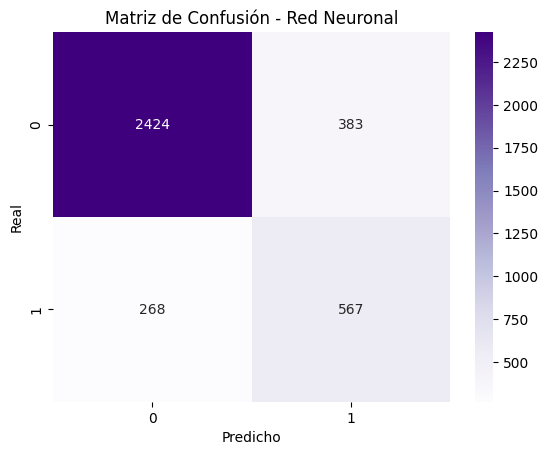

In [364]:
# Obtener probabilidades en Test
y_probs_test_nn = nn_clasificacion.model.predict(X_test).flatten()
y_pred_test_nn = (y_probs_test_nn >= umbral_optimo_nn).astype(int)

print("\n--- REPORTE DE CLASIFICACIÓN (Red Neuronal) ---")
print(classification_report(y_test_class, y_pred_test_nn))

# Matriz de Confusión
cm = confusion_matrix(y_test_class, y_pred_test_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión - Red Neuronal')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

La red neuronal de clasificación supera a la regresión logística en todas las métricas, obteniendo un F1 de 0.64, accuracy de 0.82 y AUC de 0.866, con un umbral óptimo de 0.576. La matriz de confusión refleja un mejor balance entre clases respecto a la logística, aunque la brecha entre accuracy de entrenamiento (0.86) y validación (0.80) indica un overfitting leve que no compromete la generalización del modelo.

# **5. Optimización de hiperparámetros**

## Regresión lineal múltiple

Se eligió RandomizedSearchCV como método de optimización por ser más eficiente computacionalmente cuando el espacio de búsqueda es grande o continuo.

### Optimización de Regularización

In [371]:
# Ridge
random_ridge = RandomizedSearchCV(
    Ridge(),
    {'alpha': loguniform(1e-3, 100)},
    n_iter=20, scoring='neg_mean_absolute_error', cv=5, random_state=42
)
random_ridge.fit(X_train, y_train_reg)
print(f"Mejor alpha Ridge: {random_ridge.best_params_} | MAE: {-random_ridge.best_score_:.4f}")

# Lasso
random_lasso = RandomizedSearchCV(
    Lasso(max_iter=2000),
    {'alpha': loguniform(1e-3, 10)},
    n_iter=20, scoring='neg_mean_absolute_error', cv=5, random_state=42
)
random_lasso.fit(X_train, y_train_reg)
print(f"Mejor alpha Lasso: {random_lasso.best_params_} | MAE: {-random_lasso.best_score_:.4f}")

# ElasticNet
random_elastic = RandomizedSearchCV(
    ElasticNet(max_iter=2000),
    {'alpha': loguniform(1e-3, 10), 'l1_ratio': uniform(0.1, 0.9)},
    n_iter=20, scoring='neg_mean_absolute_error', cv=5, random_state=42
)
random_elastic.fit(X_train, y_train_reg)
print(f"Mejor ElasticNet: {random_elastic.best_params_} | MAE: {-random_elastic.best_score_:.4f}")

Mejor alpha Ridge: {'alpha': np.float64(70.72114131472235)} | MAE: 3.0782
Mejor alpha Lasso: {'alpha': np.float64(0.679657809075816)} | MAE: 2.9654
Mejor ElasticNet: {'alpha': np.float64(0.5456725485601477), 'l1_ratio': np.float64(0.4961372443656412)} | MAE: 2.9094


Ridge empeoró respecto al valor por defecto, lo que sugiere que la regularización L2 fuerte no beneficia a este problema. Lasso mejoró levemente.ElasticNet obtuvo el mejor MAE de todos los modelos lineales (2.91), combinando L1 y L2 con un l1_ratio cercano a 0.5, lo que indica que ambos tipos de regularización aportan por igual.

Sin embargo, la mejora es marginal respecto a los valores sin optimizar, lo que refuerza la idea de que la lluvia tiene una distribución no lineal que ningún modelo lineal puede capturar bien independientemente de los hiperparámetros elegidos.

## Clasificación binaria

In [372]:
param_dist_log = {
    'C': loguniform(1e-3, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

random_log = RandomizedSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_dist_log,
    n_iter=20,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_log.fit(X_train_smote, y_train_smote)

print(f"Mejores parámetros Logística: {random_log.best_params_}")
print(f"Mejor F1-score en validación: {random_log.best_score_:.4f}")

best_log_model = random_log.best_estimator_

Mejores parámetros Logística: {'C': np.float64(0.0010090061869151559), 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-score en validación: 0.7707


In [373]:
# Probabilidades en validación para encontrar umbral óptimo
y_probs_val_log_opt = best_log_model.predict_proba(X_val)[:, 1]
umbrales = np.linspace(0, 1, 100)
f1_val = [f1_score(y_val_class, (y_probs_val_log_opt >= t).astype(int)) for t in umbrales]
umbral_log_opt = umbrales[np.argmax(f1_val)]

# Evaluación en test con umbral óptimo
y_probs_test_log_opt = best_log_model.predict_proba(X_test)[:, 1]
y_pred_test_log_opt = (y_probs_test_log_opt >= umbral_log_opt).astype(int)

print(f"--- LOGÍSTICA OPTIMIZADA (Umbral {umbral_log_opt:.4f}) ---")
print(classification_report(y_test_class, y_pred_test_log_opt))

--- LOGÍSTICA OPTIMIZADA (Umbral 0.5455) ---
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      2807
           1       0.52      0.75      0.61       835

    accuracy                           0.78      3642
   macro avg       0.72      0.77      0.73      3642
weighted avg       0.82      0.78      0.80      3642



La logística optimizada con RandomizedSearchCV obtuvo un C de 0.001, lo que implica una regularización L2 muy fuerte que restringe en exceso la capacidad del modelo. Si bien este valor maximizó el F1 en la validación cruzada sobre datos SMOTE, no generalizó igual sobre el test real desbalanceado, obteniendo un F1 de 0.61 levemente inferior al modelo base (0.63). Esto evidencia que optimizar sobre datos sintéticos no siempre garantiza mejora en la distribución real, y que la regularización excesiva puede introducir underfitting en este tipo de problemas.

## Redes neuronales

In [376]:
# Valores a probar
learning_rates = [0.01, 0.001]
dropouts = [0.2, 0.4]

mejor_auc = 0
mejor_config = {}

for lr in learning_rates:
    for dr in dropouts:
        print(f"\nProbando: LR={lr}, Dropout={dr}")

        nn = RedNeuronalClasificadora(épocas=50, batch_size=64, learning_rate=lr, dropout_rate=dr)
        nn.build_model(input_shape=X_train.shape[1])
        nn.train(X_train_smote, y_train_smote, X_val, y_val_class)

        # Evaluamos con AUC en validación
        y_probs_val = nn.model.predict(X_val).flatten()
        auc_val = roc_auc_score(y_val_class, y_probs_val)
        print(f"AUC en validación: {auc_val:.4f}")

        if auc_val > mejor_auc:
            mejor_auc = auc_val
            mejor_config = {'learning_rate': lr, 'dropout_rate': dr}
            mejor_modelo = nn

print(f"\nMejor configuración NN: {mejor_config}")
print(f"Mejor AUC en validación: {mejor_auc:.4f}")


Probando: LR=0.01, Dropout=0.2
Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7674 - auc: 0.8483 - loss: 0.4866 - val_accuracy: 0.7741 - val_auc: 0.8614 - val_loss: 0.4613
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7851 - auc: 0.8695 - loss: 0.4530 - val_accuracy: 0.7738 - val_auc: 0.8618 - val_loss: 0.4511
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7927 - auc: 0.8775 - loss: 0.4410 - val_accuracy: 0.7800 - val_auc: 0.8651 - val_loss: 0.4292
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7960 - auc: 0.8815 - loss: 0.4330 - val_accuracy: 0.7834 - val_auc: 0.8684 - val_loss: 0.4192
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7995 - auc: 0.8846 - loss: 0.4271 - val_accuracy: 0.7899 - val_auc: 0.8638 - val_loss: 0.4189
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8036 - auc: 0.8869 - loss: 0.4243 - val_accuracy: 0.7566 - val_auc: 0.8637 - val_loss: 0.4467
Epoch 7

In [377]:
# Métricas finales de la NN Clasificación Optimizada en TEST
y_probs_final_nn = nn_clasificacion.model.predict(X_test).flatten()

# Umbral que maximizó F1 en validación
y_pred_final_nn = (y_probs_final_nn >= umbral_optimo_nn).astype(int)

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

print("--- RESULTADOS FINALES PARA LA COMPARATIVA ---")
print(f"NN - F1-Score: {f1_score(y_test_class, y_pred_final_nn):.4f}")
print(f"NN - Accuracy: {accuracy_score(y_test_class, y_pred_final_nn):.4f}")
print(f"NN - AUC: {roc_auc_score(y_test_class, y_probs_final_nn):.4f}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
--- RESULTADOS FINALES PARA LA COMPARATIVA ---
NN - F1-Score: 0.6353
NN - Accuracy: 0.8213
NN - AUC: 0.8684


La red neuronal de clasificación optimizada obtuvo el mejor rendimiento entre todos los modelos de clasificación evaluados, con un F1 de 0.64, accuracy de 0.82 y AUC de 0.87, confirmando que su capacidad de capturar relaciones no lineales le permite generalizar mejor que la regresión logística tanto base como optimizada.



# **6. Comparación de modelos**

In [378]:
# Modelos base para comparar
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_reg)

model_log_base = LogisticRegression(max_iter=1000, random_state=42)
model_log_base.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42)

## Regresión

In [379]:
def obtener_metricas_reg(model, X_test, y_test, nombre):
    preds = model.predict(X_test)
    if hasattr(preds, "flatten"): preds = preds.flatten()
    return {
        'Modelo': nombre,
        'MAE (mm)': mean_absolute_error(y_test, preds),
        'R2 Score': r2_score(y_test, preds)
    }

reg_results = []
reg_results.append(obtener_metricas_reg(lin_reg, X_test, y_test_reg, "Regresión Lineal Base"))
reg_results.append(obtener_metricas_reg(random_ridge.best_estimator_, X_test, y_test_reg, "Ridge Optimizado"))
reg_results.append(obtener_metricas_reg(random_lasso.best_estimator_, X_test, y_test_reg, "Lasso Optimizado"))
reg_results.append(obtener_metricas_reg(random_elastic.best_estimator_, X_test, y_test_reg, "ElasticNet Optimizado"))
reg_results.append(obtener_metricas_reg(nn_regresion, X_test, y_test_reg, "Red Neuronal"))

df_reg = pd.DataFrame(reg_results).sort_values(by='MAE (mm)')
print("--- COMPARATIVA DE REGRESIÓN ---")
display(df_reg)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
--- COMPARATIVA DE REGRESIÓN ---


Modelo  MAE (mm)  R2 Score
4           Red Neuronal  2.087526  0.376831
3  ElasticNet Optimizado  2.815666  0.201577
2       Lasso Optimizado  2.871369  0.181317
1       Ridge Optimizado  2.985722  0.246287
0  Regresión Lineal Base  3.005111  0.246238

La red neuronal lidera claramente con el menor MAE (2.09mm) y mayor R² (0.38), seguida por los modelos lineales con regularización donde ElasticNet optimizado obtiene el mejor MAE (2.82mm).

## Clasificación

In [380]:
def obtener_metricas_class(model, X_test, y_test, nombre, threshold=0.5):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else: # Red Neuronal
        probs = model.predict(X_test).flatten()

    preds = (probs >= threshold).astype(int)
    return {
        'Modelo': nombre,
        'F1-Score (Clase 1)': f1_score(y_test, preds),
        'Accuracy': accuracy_score(y_test, preds),
        'AUC-ROC': roc_auc_score(y_test, probs),
        'Umbral': threshold
    }

class_results = []
class_results.append(obtener_metricas_class(model_log_base, X_test, y_test_class, "Logística Base", 0.5))
class_results.append(obtener_metricas_class(best_log_model, X_test, y_test_class, "Logística Optimizada", umbral_log_opt))
class_results.append(obtener_metricas_class(nn_clasificacion.model, X_test, y_test_class, "Red Neuronal Optimizada", umbral_optimo_nn))

df_class = pd.DataFrame(class_results).sort_values(by='F1-Score (Clase 1)', ascending=False)
print("\n--- COMPARATIVA DE CLASIFICACIÓN ---")
display(df_class)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- COMPARATIVA DE CLASIFICACIÓN ---


Modelo  F1-Score (Clase 1)  Accuracy   AUC-ROC    Umbral
2  Red Neuronal Optimizada            0.635294  0.821252  0.868424  0.575758
0           Logística Base            0.616570  0.781439  0.856281  0.500000
1     Logística Optimizada            0.613803  0.783361  0.849289  0.545455

La red neuronal optimizada lidera en todas las métricas con un F1 de 0.64, accuracy de 0.82 y AUC de 0.87, confirmando su superioridad para capturar relaciones no lineales. La logística base supera levemente a la optimizada en F1 (0.62 vs 0.61) y AUC (0.856 vs 0.849), evidenciando que la optimización sobre datos SMOTE no garantizó mejora en la distribución real del test, como se analizó anteriormente.

# **7. Explicabilidad**

In [381]:
feature_names=X_train.columns.values
feature_names

<StringArray>
[        'MinTemp (°C)',         'MaxTemp (°C)',   'RainfallToday (mm)',
     'Evaporation (mm)',         'Sunshine (h)', 'WindGustSpeed (km/h)',
  'WindSpeed9am (km/h)',  'WindSpeed3pm (km/h)',      'Humidity9am (%)',
      'Humidity3pm (%)',    'Pressure9am (hPa)',    'Pressure3pm (hPa)',
     'Cloud9am (oktas)',     'Cloud3pm (oktas)',         'Temp9am (°C)',
         'Temp3pm (°C)',            'RainToday',      'WindGustDir_sin',
      'WindGustDir_cos',       'WindDir9am_sin',       'WindDir9am_cos',
       'WindDir3pm_sin',       'WindDir3pm_cos',            'Month_sin',
            'Month_cos']
Length: 25, dtype: str

## Red neuronal regresión

In [382]:
# Crea un objeto explainer SHAP
explainer = shap.DeepExplainer(nn_regresion.model, X_train)

In [383]:
# Crea un objeto explainer SHAP
explainer = shap.DeepExplainer(nn_regresion.model, X_train.values)

In [384]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test.values)

In [385]:
shap_values.shape

(3642, 25, 1)

In [386]:
explainer.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.992449], dtype=float32)>

### Interpretación local

In [387]:
shap_values[0]

array([[-0.18365457],
       [ 0.01152567],
       [-0.05717766],
       [ 0.19910268],
       [-0.03645145],
       [-0.32140968],
       [ 0.07294463],
       [ 0.0218367 ],
       [ 0.06655477],
       [-1.1926026 ],
       [ 0.00590781],
       [ 0.59230801],
       [-0.15699866],
       [ 0.004583  ],
       [-0.49388907],
       [-0.04439076],
       [ 0.00986112],
       [-0.04516733],
       [ 0.07315091],
       [-0.11587744],
       [-0.06389055],
       [-0.09645082],
       [ 0.11685965],
       [ 0.4484658 ],
       [ 0.02668896]])

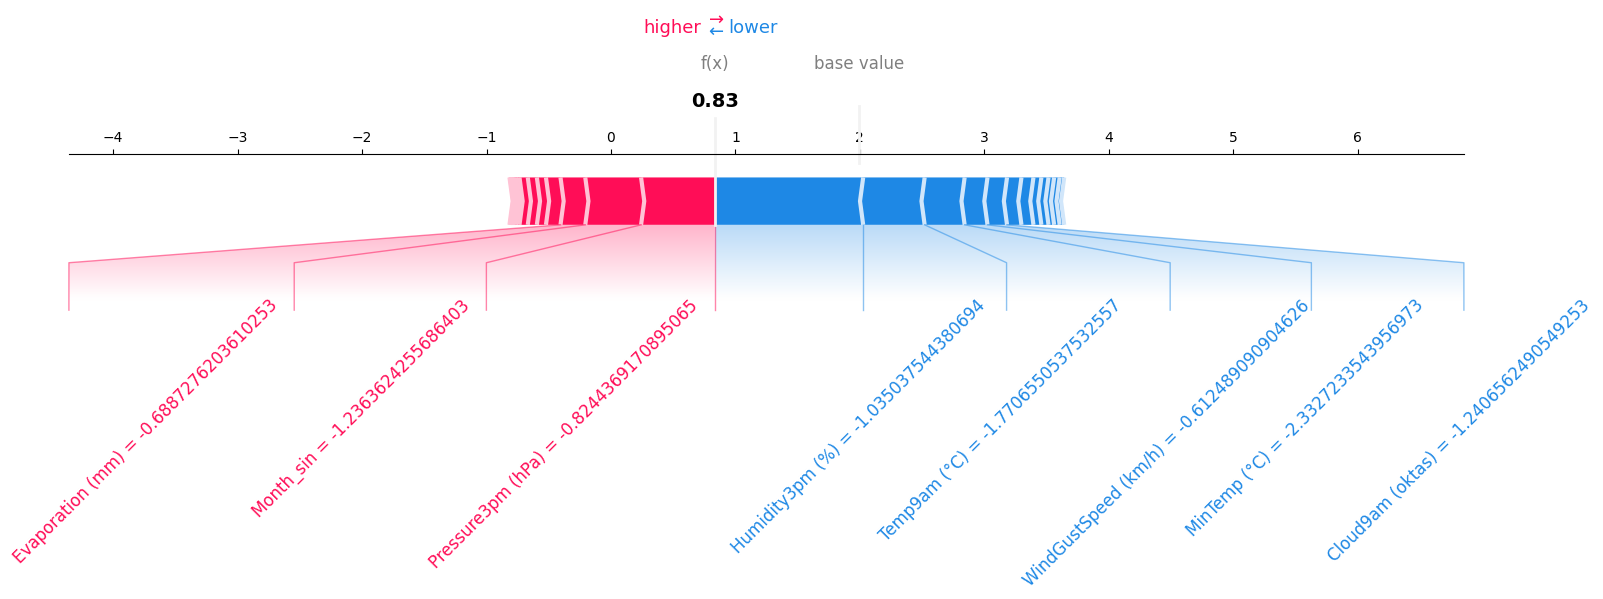

In [388]:
index=0
shap.force_plot(
    explainer.expected_value.numpy(),
    shap_values[index].flatten(),
    X_test.iloc[[index]],
    feature_names=feature_names,
    matplotlib=True,
    figsize=(18, 4),
    text_rotation=45
)

In [389]:
explanation = shap.Explanation(values=shap_values[index].flatten(), base_values=explainer.expected_value.numpy().item(), feature_names=feature_names)

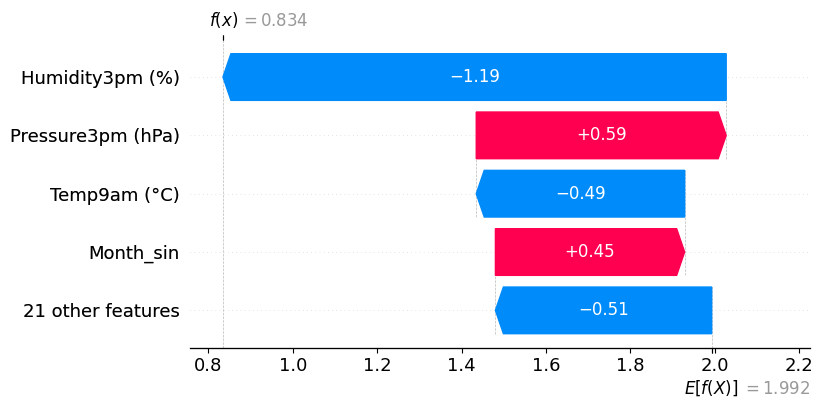

In [390]:
shap.plots.waterfall(explanation, max_display=5)

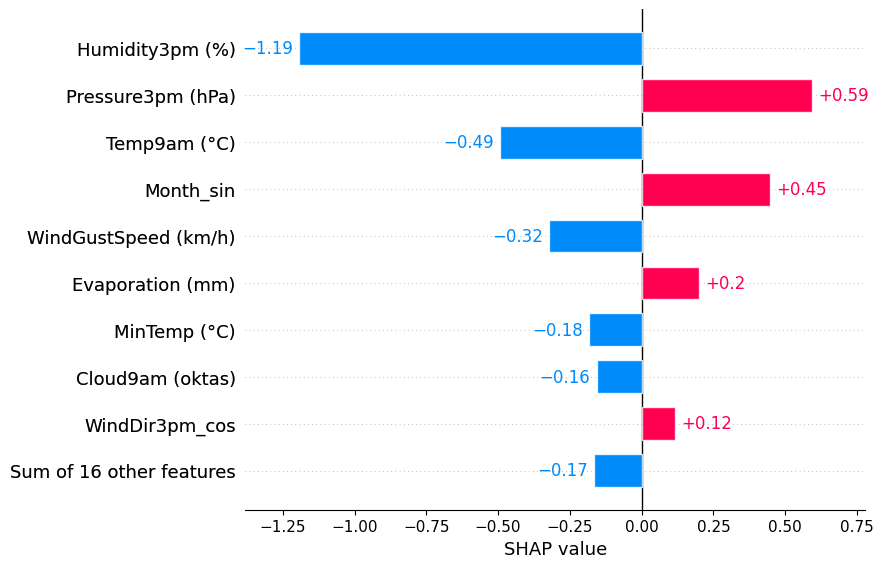

In [391]:
shap.plots.bar(explanation)

Para esta instancia particular (predicción de 0.83mm), el modelo parte de un valor base de 1.992mm y las variables más influyentes son:

-Humidity3pm (-1.19): es la variable que más reduce la predicción. Una humedad baja a las 3pm indica condiciones más secas, reduciendo la lluvia esperada para el día siguiente.

-Pressure3pm (+0.59): la presión alta empuja la predicción hacia arriba, aunque en meteorología la alta presión generalmente se asocia a tiempo seco, por lo que este efecto puede estar capturando interacciones complejas con otras variables.

-Temp9am (-0.49): una temperatura alta a las 9am reduce la predicción, posiblemente asociado a días más secos.

-Month_sin (+0.45): la componente estacional del mes indica que el período del año contribuye positivamente, reflejando la estacionalidad de las lluvias australianas.

En conjunto, las variables que empujan hacia abajo dominan sobre las que empujan hacia arriba, resultando en una predicción de 0.83mm, por debajo del valor base de 1.99mm, lo que es consistente con un día con baja probabilidad de lluvia significativa.

### Interpretabilidad global

In [392]:
explanation = shap.Explanation(values=shap_values.squeeze(), base_values=explainer.expected_value.numpy(), feature_names=feature_names, data=X_test.values)

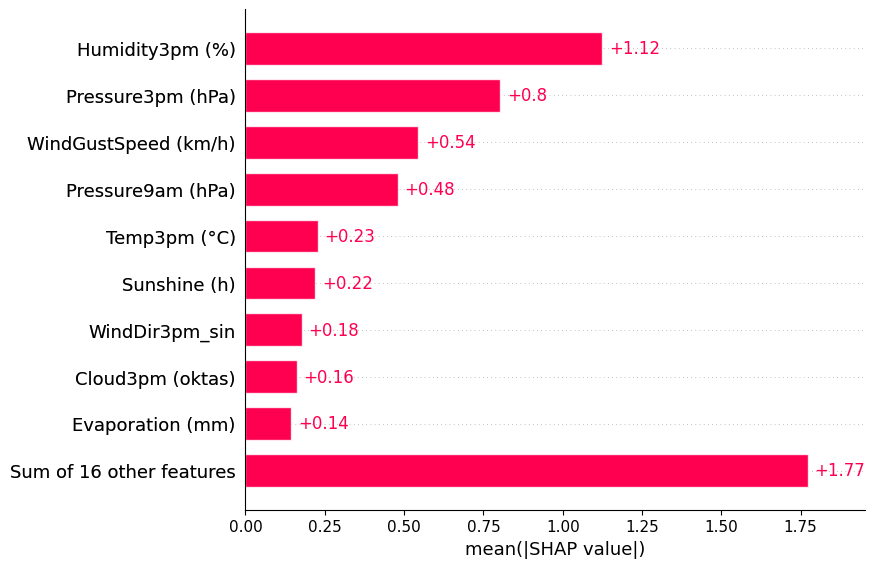

In [393]:
shap.plots.bar(explanation)

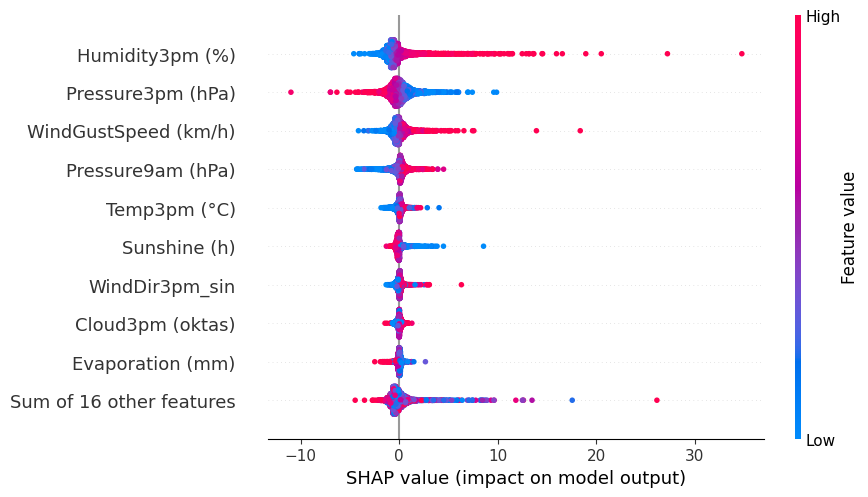

In [394]:
shap.plots.beeswarm(explanation)

-Humidity3pm (%) es la variable más influyente globalmente (+1.12), y el beeswarm confirma que valores altos (rosa) generan SHAP positivos, aumentando la predicción de lluvia, mientras que valores bajos (azul) la reducen. Esto es físicamente coherente: mayor humedad vespertina se asocia a mayor lluvia al día siguiente.

-Pressure3pm (hPa) es la segunda más importante (+0.80), con una dispersión mayor en el beeswarm, indicando que su efecto es más variable según la instancia.

-WindGustSpeed (km/h) (+0.54) muestra que vientos más fuertes incrementan los mm predichos, lo cual tiene sentido ya que las ráfagas intensas suelen preceder lluvias.

-Pressure9am (hPa) (+0.48) aporta información complementaria a Pressure3pm, aunque con menor impacto.

-El resto de variables (Temp3pm, Sunshine, Cloud3pm, etc.) tienen impactos menores e individuales por debajo de 0.25, siendo su contribución conjunta significativa (+1.77 para las 16 restantes).

## Red neuronal clasificación

In [395]:
# Crea un objeto explainer SHAP
explainer2 = shap.DeepExplainer(nn_clasificacion.model, X_train.values)

In [396]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer2.shap_values(X_test.values)

In [397]:
shap_values.shape

(3642, 25, 1)

### Interpretabilidad local

In [398]:
index=0

In [399]:
shap_values[index]

array([[-0.00393099],
       [ 0.00511267],
       [-0.00074589],
       [ 0.02007716],
       [ 0.01806259],
       [-0.05826229],
       [-0.03920339],
       [-0.00668913],
       [ 0.00600546],
       [-0.12309955],
       [-0.00824166],
       [ 0.01659656],
       [ 0.01871569],
       [-0.00587784],
       [-0.01331853],
       [ 0.00371987],
       [-0.00867891],
       [-0.02900635],
       [ 0.02313001],
       [-0.01690829],
       [-0.02959718],
       [-0.00905046],
       [ 0.01385132],
       [-0.03745893],
       [-0.03884243]])

In [400]:
explainer2.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.32095584], dtype=float32)>

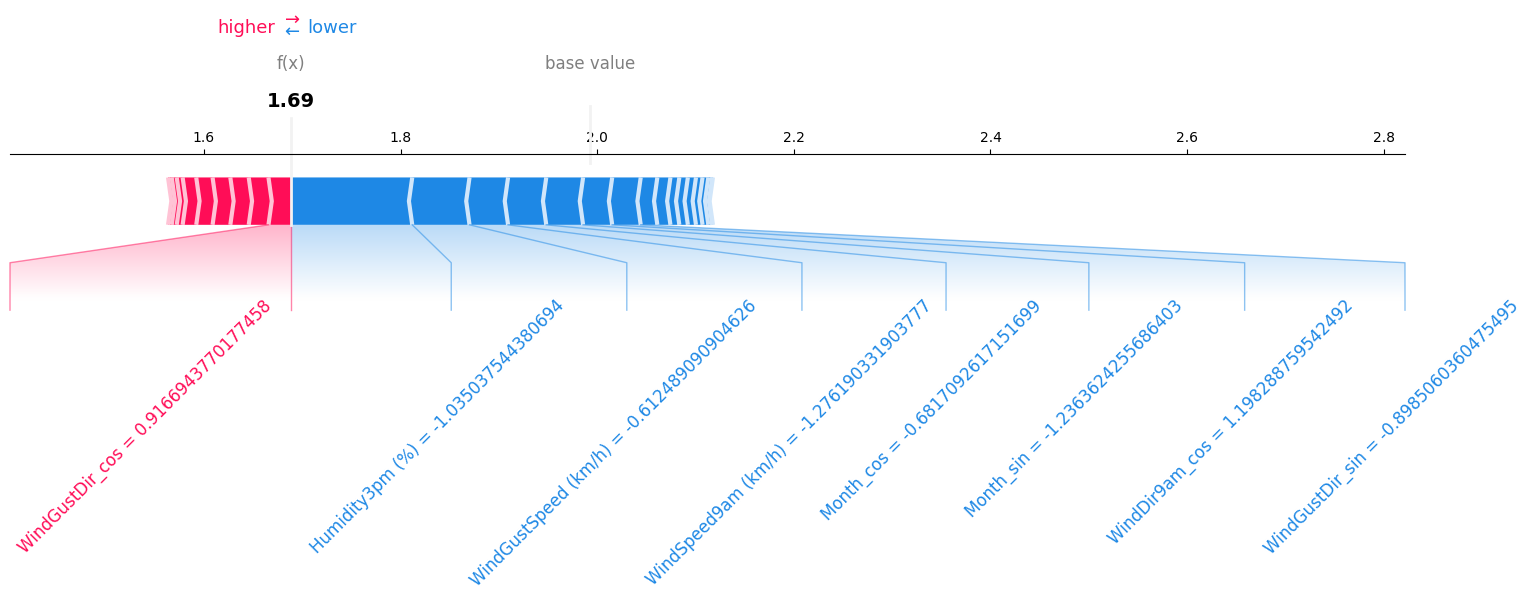

In [408]:
shap.force_plot(
    explainer.expected_value.numpy(),
    shap_values[index].flatten(),
    X_test.iloc[[index]],  
    feature_names=feature_names,
    matplotlib=True,
    figsize=(18, 4),
    text_rotation=45
)

In [402]:
explanation = shap.Explanation(values=shap_values[index].flatten(), base_values=explainer2.expected_value.numpy().item(), feature_names=feature_names)

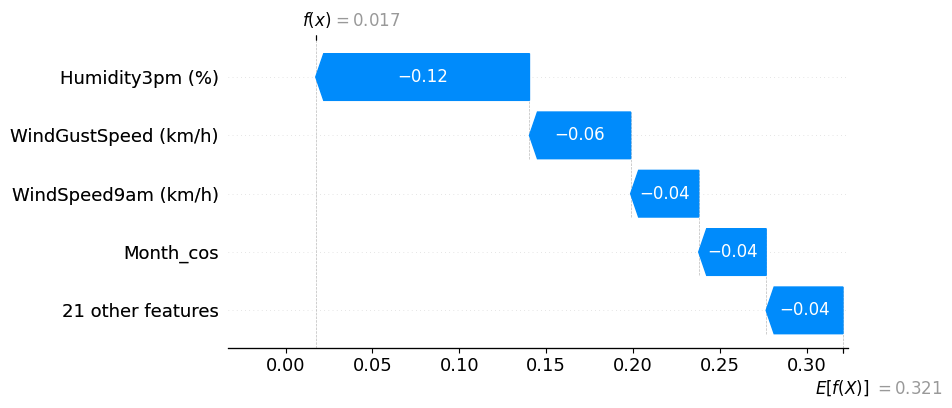

In [403]:
shap.plots.waterfall(explanation, max_display=5)

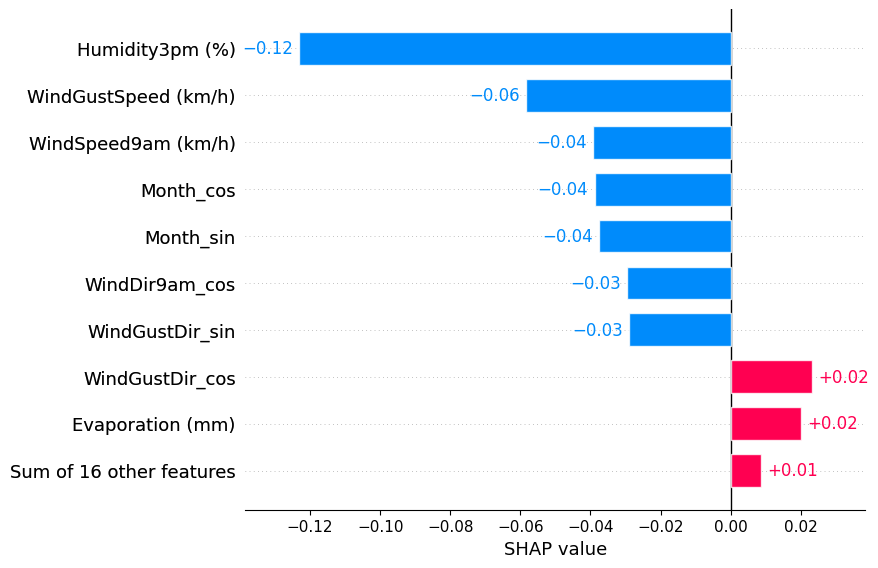

In [404]:
shap.plots.bar(explanation)

Las variables más influyentes son:

-Humidity3pm (-0.12): es la que más reduce la probabilidad de lluvia, indicando que este día particular tiene una humedad vespertina baja, condición desfavorable para precipitaciones.

-WindGustSpeed (-0.06) y WindSpeed9am (-0.04): velocidades de viento bajas también contribuyen a reducir la probabilidad, ya que la ausencia de vientos fuertes sugiere estabilidad atmosférica.

-Month_cos y Month_sin (-0.04 cada uno): la estacionalidad juega en contra de la lluvia para este período del año.

-WindGustDir_cos (+0.02): es prácticamente la única variable que empuja levemente hacia la clase positiva, pero su efecto es marginal.

En conjunto, todas las variables relevantes apuntan en la misma dirección reduciendo la probabilidad desde 0.321 hasta 0.017, lo que resulta en una predicción confiable de día sin lluvia, consistente con un perfil meteorológico de baja humedad y vientos calmos.



### Interpretabilidad global

In [405]:
explanation = shap.Explanation(values=shap_values.squeeze(), base_values=explainer2.expected_value.numpy(), feature_names=feature_names, data=X_test.values)

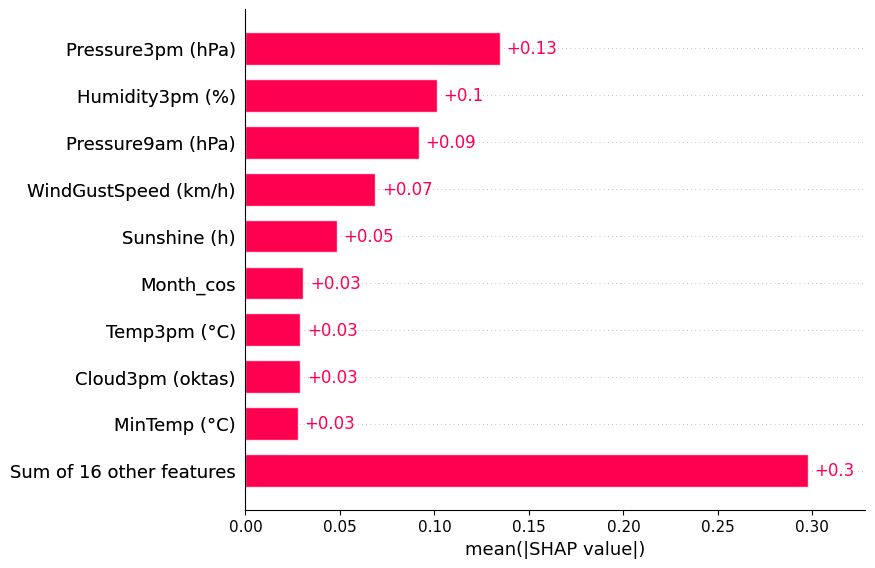

In [406]:
shap.plots.bar(explanation)

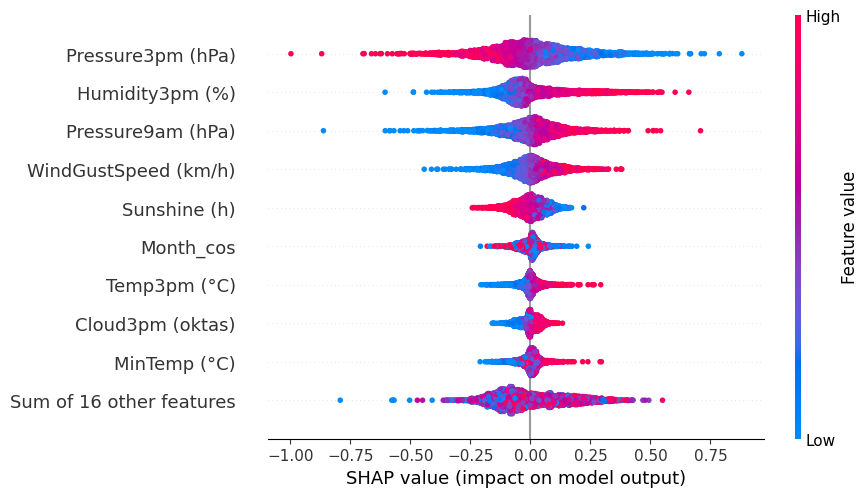

In [407]:
shap.plots.beeswarm(explanation)

Para la interpretabilidad global de la red de clasificación:

-Pressure3pm (hPa) es la variable más influyente (+0.13) y el beeswarm muestra que los valores bajos de presión (azul) generan SHAP positivos, aumentando la probabilidad de lluvia, mientras que valores altos (rosa) la reducen.

-Humidity3pm (%) (+0.10) confirma que sus valores altos incrementan la probabilidad de lluvia del día siguiente, consistente con lo observado en el modelo de regresión.

-Pressure9am (hPa) (+0.09) aporta información complementaria a Pressure3pm, capturando la tendencia de la presión a lo largo del día.

-WindGustSpeed (km/h) (+0.07) muestra que ráfagas intensas aumentan la probabilidad de lluvia.

-Sunshine (h) (+0.05) presenta un patrón inverso, donde valores altos de horas de sol (días despejados) reducen la probabilidad de lluvia al día siguiente.

-Las variables restantes tienen impactos individuales bajos (≤0.03), aunque en conjunto contribuyen significativamente (+0.30), reflejando que la clasificación de lluvia es un fenómeno multivariable donde ninguna variable por sí sola es determinante.

# **9. Conclusión**

El trabajo consistió la predicción de dos variables meteorológicas: la estimación de la cantidad de lluvia del día siguiente (RainfallTomorrow) y detección de si lloverá o no (RainTomorrow). En regresión, los modelos lineales evidenciaron underfitting debido a la distribución sesgada de la lluvia y su naturaleza no lineal, siendo la red neuronal el modelo superior. En clasificación, el desbalance de clases requirió estrategias de balanceo, y nuevamente la red neuronal optimizada lideró todas las métricas.

El análisis SHAP reveló que Humidity3pm y Pressure3pm son las variables más determinantes en ambas tareas, mientras que ninguna variable individual resultó suficiente por sí sola. La optimización de hiperparámetros sobre datos SMOTE no garantizó mejoras en la distribución real del test.

En conclusión, las redes neuronales demostraron ser los modelos más adecuados para variables objetivo gracias a su capacidad de capturar relaciones no lineales entre variables climáticas.